In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import csv
import json

import numpy as np
import matplotlib.pyplot as plt

import sacrebleu
import soundfile as sf

import copy
import yaml
import math
import torch
from tqdm.notebook import tqdm

from IPython.display import display, Audio

def read_logs(path):
    logs = []
    with open(path, "r") as r:
        for l in r.readlines():
            l = l.strip()
            if l != "":
                logs.append(json.loads(l))
    return logs

def write_logs(logs, path):
    with open(path, "w") as w:
        for log in logs:
            w.write(json.dumps(log) + "\n")

def read_wav(wav_path):
    if ':' in wav_path:
        wav_path, offset, duration = wav_path.split(':')
        offset = int(offset)
        duration = int(duration)
    else:
        offset = 0
        duration = -1
    source, rate = sf.read(wav_path, start=offset, frames=duration)
    return source, rate

def read_tsv(tsv_path):
    import csv
    with open(tsv_path) as f:
        reader = csv.DictReader(
            f,
            delimiter="\t",
            quotechar=None,
            doublequote=False,
            lineterminator="\n",
            quoting=csv.QUOTE_NONE,
        )
        samples = [dict(e) for e in reader]
    return samples

def write_tsv(samples, tsv_path):
    with open(tsv_path, "w") as w:
        writer = csv.DictWriter(
            w,
            samples[0].keys(),
            delimiter="\t",
            quotechar=None,
            doublequote=False,
            lineterminator="\n",
            quoting=csv.QUOTE_NONE,
        )
        writer.writeheader()
        writer.writerows(samples)

def play(audio_path):
    display(Audio(read_wav(audio_path)[0], rate=16000))

# NLLB

In [13]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

"Le chef de l'ONU dit qu'il n'y a pas de solution militaire en Syrie"

In [18]:
article = "Hello"
inputs = tokenizer(article, return_tensors="pt")

translated_tokens = model.generate(
    **inputs, forced_bos_token_id=tokenizer.convert_tokens_to_ids("zho_Hans"), max_length=30
)
tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]

'您好.'

# QWEN

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="cuda"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
text = "翻译成英文：你好。"
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

In [9]:
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=10,
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


In [10]:
print(response)

 How are you doing?


# inconsistency between online and simuleval

In [16]:
online_sources = []
for i in range(16):
    online_sources.append(np.load('/home/siqiouya/work/sllama/online_source_{}.npy'.format(i)))
simuleval_sources = []
for i in range(16):
    simuleval_sources.append(np.load('/home/siqiouya/work/sllama/source_{}.npy'.format(i)))

In [17]:
online_sources[0], simuleval_sources[0]

(array([ 0.        ,  0.        ,  0.        , ..., -0.11690447,
        -0.09129377, -0.11185333], dtype=float32),
 array([ 0.        ,  0.        ,  0.        , ...,  0.03414917,
         0.00436401, -0.05111694]))

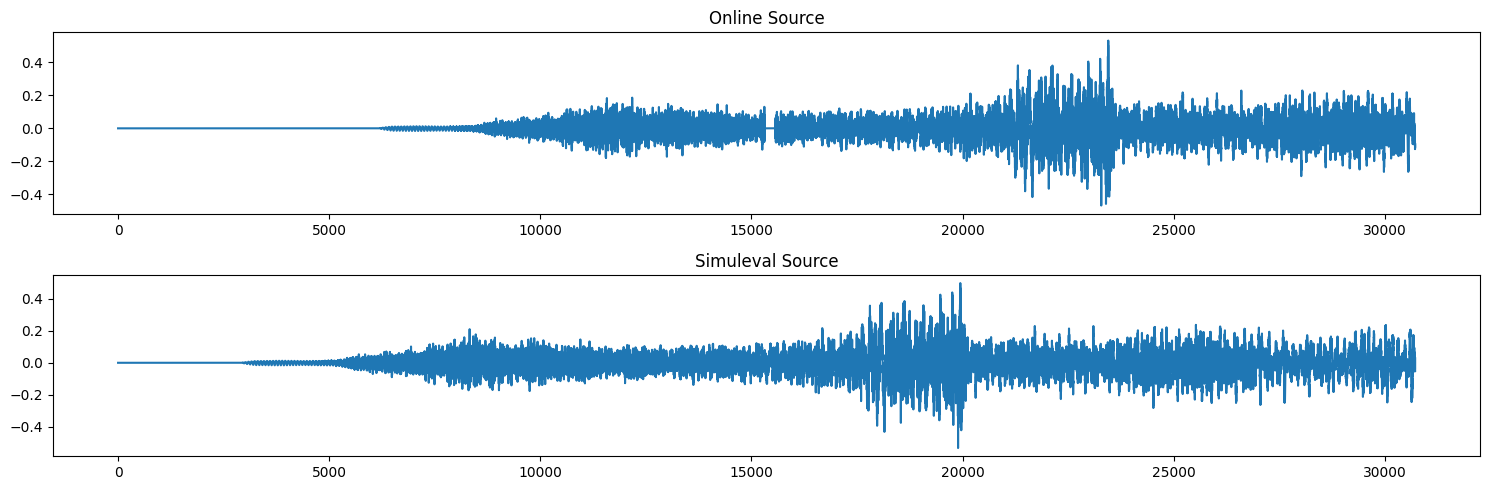

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(online_sources[0])
plt.title('Online Source')
plt.subplot(212) 
plt.plot(simuleval_sources[0])
plt.title('Simuleval Source')
plt.tight_layout()
plt.show()


# SacreBLEU

In [ ]:
import sacrebleu
scorer = sacrebleu.BLEU()
scorer.get_signature()

# tst-COMMON

In [2]:
wav_paths = []
with open("/compute/babel-14-5/siqiouya/en-zh/tst-COMMON_full.source") as f:
    for line in f:
        wav_paths.append(line.strip())

In [3]:
infos = []
for wav_path in wav_paths:
    info = sf.info(wav_path)
    infos.append(info)

In [4]:
durations = []
for info in infos:
    durations.append(info.duration / 60)

In [5]:
durations = np.array(durations)
(durations > 10).sum()

11

In [6]:
durations.max()

23.683580208333336

In [7]:
durations.sum()

294.6705166666667

In [165]:
for m in range(1, 5):
    seg_size = m * 960
    path = "/compute/babel-5-23/siqiouya/runs/en-zh/8B-traj-s2-v3.5_llama3/last.ckpt/simul-results-full-betterfilterbadwords/cache1000_seg{}_beam4_ms0_nrnl100_nrns5/instances.log".format(seg_size)
    logs = read_logs(path)
    logs_less10 = [log for log in logs if log['source_length'] / 1000 / 60 < 10]
    logs_more10 = [log for log in logs if log['source_length'] / 1000 / 60 >= 10]
    write_logs(logs_less10, path.replace(".log", "_less10.log"))
    write_logs(logs_more10, path.replace(".log", "_more10.log"))

In [162]:
len(logs_less10), len(logs_more10)

(16, 11)

# absolute position embedding

In [5]:
def sinusoidal_positional_embedding(offset, length, d_model):
    half_dim = d_model // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float) * -emb)
    emb = torch.arange(offset, offset + length, dtype=torch.float).unsqueeze(
        1
    ) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1).view(
        length, -1
    )
    if d_model % 2 == 1:
        # zero pad
        emb = torch.cat([emb, torch.zeros(length, 1)], dim=1)
    return emb

In [8]:
sinusoidal_positional_embedding(2, 10, 10)

tensor([[ 9.0930e-01,  1.9867e-01,  1.9999e-02,  2.0000e-03,  2.0000e-04,
         -4.1615e-01,  9.8007e-01,  9.9980e-01,  1.0000e+00,  1.0000e+00],
        [ 1.4112e-01,  2.9552e-01,  2.9995e-02,  3.0000e-03,  3.0000e-04,
         -9.8999e-01,  9.5534e-01,  9.9955e-01,  1.0000e+00,  1.0000e+00],
        [-7.5680e-01,  3.8942e-01,  3.9989e-02,  4.0000e-03,  4.0000e-04,
         -6.5364e-01,  9.2106e-01,  9.9920e-01,  9.9999e-01,  1.0000e+00],
        [-9.5892e-01,  4.7943e-01,  4.9979e-02,  5.0000e-03,  5.0000e-04,
          2.8366e-01,  8.7758e-01,  9.9875e-01,  9.9999e-01,  1.0000e+00],
        [-2.7942e-01,  5.6464e-01,  5.9964e-02,  6.0000e-03,  6.0000e-04,
          9.6017e-01,  8.2534e-01,  9.9820e-01,  9.9998e-01,  1.0000e+00],
        [ 6.5699e-01,  6.4422e-01,  6.9943e-02,  6.9999e-03,  7.0000e-04,
          7.5390e-01,  7.6484e-01,  9.9755e-01,  9.9998e-01,  1.0000e+00],
        [ 9.8936e-01,  7.1736e-01,  7.9915e-02,  7.9999e-03,  8.0000e-04,
         -1.4550e-01,  6.9671e-0

In [9]:
from fairseq.modules.sinusoidal_positional_embedding import SinusoidalPositionalEmbedding

# Mix data

In [109]:
lang = 'es'
split = 'dev'

In [110]:
split_full = f"{split}_st_{lang}{'_ft' if lang == 'zh' and split == 'train' else ''}"

In [111]:
print(split_full)

dev_st_es


In [112]:
samples_30 = read_tsv(f"/compute/babel-14-5/siqiouya/en-{lang}/{split_full}_nospeaker_traj_30_filtered.tsv")
samples = read_tsv(f"/compute/babel-14-5/siqiouya/en-{lang}/{split_full}_nospeaker_traj.tsv")

In [113]:
len(samples_30), len(samples)

(454, 1183)

In [114]:
for x in samples:
    if 'src_phoneme' in x:
        x.pop('src_phoneme')
    if 'src_segments' in x:
        x.pop('src_segments')

In [115]:
samples = [x for x in samples if type(eval(x['trajectory'])) == list]

In [116]:
len(samples)

1183

In [122]:
import sys
sys.path.append("/home/siqiouya/work/sllama")
from train.dataset import PromptSpeechToTextDatasetCreator
dataset_mix = PromptSpeechToTextDatasetCreator.from_tsv(
    root=f"/compute/babel-14-5/siqiouya/en-{lang}/",
    split=f"dev_st_es_nospeaker_traj_30mix_filtered",
)

In [123]:
for i in tqdm(range(len(dataset_mix))):
    if dataset_mix.trajectories[i] is None:
        print(dataset_mix[i])
        break

  0%|          | 0/1637 [00:00<?, ?it/s]

In [120]:
new_samples = samples_30 + samples
write_tsv(new_samples, f"/compute/babel-14-5/siqiouya/en-{lang}/{split_full}_nospeaker_traj_30mix_filtered.tsv")

In [121]:
f"/compute/babel-14-5/siqiouya/en-{lang}/{split_full}_nospeaker_traj_30mix_filtered.tsv"

'/compute/babel-14-5/siqiouya/en-es/dev_st_es_nospeaker_traj_30mix_filtered.tsv'

# RTF

In [134]:
suffices = ['']

rtfs = []
for seg_size in range(960, 4000, 960):
    instances = read_logs("/compute/babel-5-23/siqiouya/runs/en-zh/8B-traj-s2-v3.6/last.ckpt/simul-results-full-betterfilterbadwords/cache1000_seg{}_beam4_ms0_nrnl100_nrns5/instances.log".format(seg_size))

    sum_audio_len = 0
    sum_comp_len = 0
    for inst in instances:
        audio_len = inst['delays'][-1]
        comp_len = inst['elapsed'][-1] - audio_len
        sum_audio_len += audio_len
        sum_comp_len += comp_len
    print("seg {} RTF: {:.3f}".format(seg_size, sum_comp_len / sum_audio_len))
    rtfs.append(sum_comp_len / sum_audio_len)
print(rtfs)


seg 960 RTF: 0.434
seg 1920 RTF: 0.311
seg 2880 RTF: 0.258
seg 3840 RTF: 0.240
[0.43420646638745586, 0.3105447250020244, 0.2577829749858482, 0.2402853461595036]


In [3]:
# StreamAtt
suffices = ['']

rtfs = []
for fn in range(1, 8):
    instances = read_logs("/compute/babel-5-23/siqiouya/runs/en-es/8B-s2-bi-v3.5.2/last.ckpt/streamatt/bsz1_layer14_t40_d10_fn{}/instances.log".format(fn))

    sum_audio_len = 0
    sum_comp_len = 0
    for inst in instances:
        audio_len = inst['delays'][-1]
        comp_len = inst['elapsed'][-1] - audio_len
        sum_audio_len += audio_len
        sum_comp_len += comp_len
    
    try:
        print("fn {} RTF: {:.3f}".format(fn, sum_comp_len / sum_audio_len))
        rtfs.append(sum_comp_len / sum_audio_len)
    except:
        pass
print(rtfs)


fn 1 RTF: 0.627
fn 2 RTF: 0.660
fn 3 RTF: 0.749
fn 4 RTF: 0.863
fn 5 RTF: 0.865
fn 6 RTF: 0.963
fn 7 RTF: 0.902
[0.6272766492708965, 0.6602332743256539, 0.7490266849020142, 0.8632729736505114, 0.8652987829525057, 0.9626827018304407, 0.9023871640602232]


# filter speaker information

In [2]:
import re
import csv
from collections import defaultdict

def extract_names_and_ted_talks(samples):
    ted_talk_dict = defaultdict(set)
    
    # Regex for extracting names: matches 'Firstname Lastname:' and initials like 'CA:' or 'RSW:'
    name_regex = re.compile(r'\b(?<!\")(Audience|Narrator|Video|Man|Woman|Bono|Voice|Announcer|Rives|George W\. Bush|Broadcasting|Boy|Professor|Engineer|Interviewer|Shereen El-Feki|Tina|Girl|Dad|Voice):|[A-Z][a-z]+(?:\s[A-Z][a-z]+)*:|[A-Z]{1,3}:')

    error_samples = []
    cleaned_samples = []
        
    for sample in samples:
        ted_id = sample['id'].split('_')[1]
        names = name_regex.findall(sample['src_text'])
        cleaned_names = {name.strip(':').strip() for name in names}

        if len(cleaned_names) > 0:
            ted_talk_dict[ted_id].update(cleaned_names)
            error_samples.append(sample)
        else:
            cleaned_samples.append(sample)

    return ted_talk_dict, error_samples, cleaned_samples

# New product from Coke Japan: water salad. | New product from Coke Japan, water salad.
# Consider this: Make a decision to live a carbon-neutral life.
# Video: Don Blankenship: Let me be clear about it. | Let me be clear about it.
# Richard Koshalek: [Unclear] starts from 2004. | THANK YOU. # (2400 frames) delete short utterance
# DP: Wow.	| David Perry: Wow. | Wow. 
# DNA: 
# Stephen Pink's Girlfriend: | Stephen Pinks Freundin:
# Audience|Narrator|Video|Man|Woman|Bono|Voice|Announcer|Rives|George W. Bush|Broadcasting|Boy|Professor|Engineer|Interviewer|Shereen El-Feki|Tina|Girl|Dad|Voice
# Then: working concentrated, without being frazzled.	Dann: konzentriert arbeiten, ohne genervt zu werden.

In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('labse')

In [4]:
file_path = '/compute/babel-14-5/siqiouya/en-es/train_st_es.tsv'

In [5]:
samples = read_tsv(file_path)

In [13]:
last_len = len(samples)
while True:
    ted_talk_data, error_samples, cleaned_samples = extract_names_and_ted_talks(samples)

    if len(error_samples) == 0:
        break

    srcs = []
    tgts = []
    for x in error_samples:
        src = x['src_text']
        tgt = x['tgt_text']

        src = src[:src.find(':')]
        if ':' in tgt:
            tgt = tgt[:tgt.find(':')]
        elif '：' in tgt:
            tgt = tgt[:tgt.find('：')]
        else:
            tgt = ""

        srcs.append(src)
        tgts.append(tgt)

    src_embeddings = model.encode(srcs)
    tgt_embeddings = model.encode(tgts)

    sims = []
    for i in range(len(src_embeddings)):
        cosine_similarity = model.similarity(src_embeddings[i], tgt_embeddings[i]).item()
        sims.append(cosine_similarity)
    sims = np.array(sims)
    src_lens = [len(src.split(' ')) for src in srcs]
    tgt_lens = [len(tgt) if 'zh' in file_path else len(tgt.split(' ')) for tgt in tgts]
    corrected_samples = []
    
    for i in range(len(sims)):
        if re.search(r'One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|LG', srcs[i]):
            continue
        if srcs[i] != "" and tgts[i] != "" and src_lens[i] <= 3 and (tgt_lens[i] <= 3 or sims[i] > 0.5):
            # print(error_samples[i]['src_text'], error_samples[i]['tgt_text'], sims[i], sep='\n', end='\n\n')
            x = copy.deepcopy(error_samples[i])
            x['src_text'] = x['src_text'][len(srcs[i]) + 1:].strip()
            x['tgt_text'] = x['tgt_text'][len(tgts[i]) + 1:].strip()
            corrected_samples.append(x)

    samples = cleaned_samples + corrected_samples

In [17]:
ted_talk_data, error_samples, cleaned_samples = extract_names_and_ted_talks(samples)

In [ ]:
write_tsv(samples, file_path.replace('.tsv', '_nospeaker.tsv'))

In [31]:
samples = read_tsv("/compute/babel-14-5/siqiouya/en-es/train_st_es.tsv")
samples_ns = read_tsv("/compute/babel-14-5/siqiouya/en-es/train_st_es_nospeaker.tsv")

In [32]:
samples_ns_f = []
for x in samples_ns:
    if ':' in x['src_text']:
        samples_ns_f.append(x)

In [33]:
samples_f = []
for x in samples:
    if ':' in x['src_text']:
        samples_f.append(x)

# llama attention

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf/")
model = AutoModelForCausalLM.from_pretrained("/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf/")

text = "Hello, how are you?"
inputs = tokenizer(text, return_tensors="pt")
outputs = model.generate(**inputs)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Hello, how are you? I hope you're doing well. I'm here to talk about something that's been on my mind


In [4]:
outputs = model.generate(**inputs, return_dict_in_generate=True, output_attentions=True)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


In [15]:
outputs['attentions'][0][0].size()

torch.Size([1, 32, 7, 7])

# inspect es

In [2]:
samples = read_tsv("/compute/babel-14-5/siqiouya/en-es/train_st_es_traj_30_filtered.tsv")

In [8]:
x['trajectory']

"[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'Es ', 'maravilloso estar ', 'aquí para ', 'hablar de mi ', 'travesía, ', 'hablar sobre mi silla de ', 'ruedas y sobre la ', 'libertad que ', 'me ha dado.  ', 'Empecé ', 'a usar silla de ', ' ', 'ruedas a los 16 años cuando una ', ' ', 'enfermedad prolongada ', 'cambió mi forma ', 'de acceder al ']"

In [14]:
for x in samples:
    try:
        type(eval(x['trajectory'])[0])
    except:
        assert int(x['n_frames']) == 0

# CPO

In [2]:
samples = read_tsv("/compute/babel-14-5/siqiouya/en-zh/train_st_zh_ft_traj_30_filtered.tsv")

In [ ]:
print(samples[4]['src_text'], samples[4]['tgt_text'], sep='\n\n')

In [62]:
logs = read_logs("/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v3.3/last.ckpt/greedy_train_chunk30_po10k/cache4000_seg960_beam1_ms0_nrnl100_nrns3/0/instances.log")

In [ ]:
log = logs[19]
print(log['prediction'])

In [95]:
n_frame = int(log['source_length'] * 16)
stepsize = int(0.96 * 16000)
idx = -1
new_traj = []
for offset in range(0, n_frame, stepsize):
    text = ""
    while idx + 1 < len(log['delays']) and int(log['delays'][idx + 1]) * 16 < offset + stepsize:
        idx += 1
        text += log['prediction'][idx]
    new_traj.append(text)

In [ ]:
print(samples[19]['tgt_text'])

In [ ]:
wav, sr = read_wav(log['source'][0])
trajectory = new_traj

step = int(sr * 0.96)
for i, action in zip(range(0, len(wav), step), trajectory):
    display(Audio(wav[i : i + step], rate=sr, autoplay=False))
    print(i // step, "[T_START]", action, "[T_END]")

In [ ]:
wav, sr = read_wav(log['source'][0])
trajectory = new_traj

step = int(sr * 0.96)
for i, action in zip(range(0, len(wav), step), trajectory):
    if i // step >= 231 - 10 and i // step <= 231 + 10:
        display(Audio(wav[i : i + step], rate=sr, autoplay=False))
        print(i // step, "[T_START]", action, "[T_END]")

# Inspect Training po10k

In [2]:
samples = read_tsv("/compute/babel-14-5/siqiouya/en-zh/train_st_zh_ft_traj_30_filtered_po10k_gpt-4o-mini-2024-07-18_fa_traj.tsv")

In [8]:
all_samples = read_tsv("/compute/babel-14-5/siqiouya/en-zh/train_st_zh_ft_traj_30_filtered.tsv")
id2samples = {x['id']: x for x in all_samples}

In [ ]:
samples[0]

In [ ]:
print('source:', samples[100]['src_text'], end='\n\n')
print('target-gpt-4o-mini:', samples[100]['tgt_text'], end='\n\n')
print('target-original:', id2samples[samples[100]['id']]['tgt_text'], end='\n\n')

# Filter by ASR WER

In [ ]:
import glob
import os

# Path to the ASR files
base_path = "/home/siqiouya/work/sllama/data"

# Get all asr.* files

# Read and concatenate all ASR results
all_asrs = []
for i in range(8):
    with open(os.path.join(base_path, f"asr.{i}")) as f:
        asrs = [line.strip() for line in f.readlines() if line.strip() != ""]
        all_asrs.extend(asrs)

print(f"Total ASR transcriptions: {len(all_asrs)}")


In [5]:
samples = read_tsv("/compute/babel-14-5/siqiouya/en-de/dev_st_de_traj_30.tsv")

In [ ]:
len(samples)

In [9]:
from evaluate import load
wer_scorer = load("wer")

In [10]:
all_asrs = np.array(all_asrs)

In [ ]:
wers = []
for i in tqdm(range(len(samples))):
    asr_orig = samples[i]['src_text'].replace('"', '').lower()
    asr_whisper = all_asrs[i].lower()
    wer = wer_scorer.compute(predictions=[asr_orig], references=[asr_whisper])
    wers.append(wer)

In [12]:
wers = np.array(wers)

In [13]:
samples = np.array(samples)

In [ ]:
(wers > 0.4).sum(), len(wers)

In [ ]:
(wers > 0.4).nonzero()[0][:10]

In [17]:
err_samples = samples[wers > 0.4]
err_asrs = all_asrs[wers > 0.4]

In [18]:
indices = list(range(len(err_samples)))
np.random.shuffle(indices)

In [ ]:
idx = indices[1]
sample = err_samples[idx]
asr_whisper = err_asrs[idx]
print(sample['src_text'], end='\n\n')
print(sample['tgt_text'], end='\n\n')
print(asr_whisper)
play(sample['audio'])

In [22]:
# special case 1
special_words = [
    "(Music)", 
    "(Laughter)", 
    "(Applause)", 
]
# special case 2
## silence or music
## usually src_text is empty and asr is shorter than 3 words

# special case 3
## zero length audio

# special case 4 
## whisper

In [23]:
remove_mask = wers > 0.4

In [24]:
for i in range(len(samples)):
    if remove_mask[i]:
        if len(all_asrs[i].split(' ')) <= 3:
            if any(w in samples[i]['src_text'] for w in special_words) or samples[i]['src_text'] == "":
                remove_mask[i] = False
                # print(samples[i]['src_text'], end='\n\n')
                # print(samples[i]['tgt_text'], end='\n\n')
                # print(all_asrs[i])
                # play(samples[i]['audio'])
                # break


In [25]:
filtered_samples = samples[~remove_mask]

In [ ]:
indices = list(range(len(filtered_samples)))
np.random.shuffle(indices)
for i in indices[:10]:
    print(filtered_samples[i]['src_text'], end='\n\n')
    print(filtered_samples[i]['tgt_text'], end='\n\n')
    print(all_asrs[~remove_mask][i])
    try:
        play(filtered_samples[i]['audio'])
    except:
        pass

In [30]:
write_tsv(filtered_samples, "/compute/babey arel-14-5/siqiouya/en-de/dev_st_de_traj_30_filtered.tsv")

In [ ]:
samples = read_tsv("/compute/babel-14-5/siqiouya/en-de/dev_st_de_traj_30.tsv")

In [ ]:
len(samples)

In [ ]:
from evaluate import load
wer_scorer = load("wer")

In [ ]:
all_asrs = np.array(all_asrs)

In [ ]:
wers = []
for i in tqdm(range(len(samples))):
    asr_orig = samples[i]['src_text'].replace('"', '').lower()
    asr_whisper = all_asrs[i].lower()
    wer = wer_scorer.compute(predictions=[asr_orig], references=[asr_whisper])
    wers.append(wer)

In [ ]:
wers = np.array(wers)

In [ ]:
samples = np.array(samples)

In [ ]:
(wers > 0.4).sum(), len(wers)

In [ ]:
(wers > 0.4).nonzero()[0][:10]

In [ ]:
err_samples = samples[wers > 0.4]
err_asrs = all_asrs[wers > 0.4]

In [ ]:
indices = list(range(len(err_samples)))
np.random.shuffle(indices)

In [ ]:
idx = indices[1]
sample = err_samples[idx]
asr_whisper = err_asrs[idx]
print(sample['src_text'], end='\n\n')
print(sample['tgt_text'], end='\n\n')
print(asr_whisper)
play(sample['audio'])

In [ ]:
# special case 1
special_words = [
    "(Music)", 
    "(Laughter)", 
    "(Applause)", 
]
# special case 2
## silence or music
## usually src_text is empty and asr is shorter than 3 words

# special case 3
## zero length audio

# special case 4 
## whisper

In [ ]:
remove_mask = wers > 0.4

In [ ]:
for i in range(len(samples)):
    if remove_mask[i]:
        if len(all_asrs[i].split(' ')) <= 3:
            if any(w in samples[i]['src_text'] for w in special_words) or samples[i]['src_text'] == "":
                remove_mask[i] = False
                # print(samples[i]['src_text'], end='\n\n')
                # print(samples[i]['tgt_text'], end='\n\n')
                # print(all_asrs[i])
                # play(samples[i]['audio'])
                # break


In [ ]:
filtered_samples = samples[~remove_mask]

In [ ]:
indices = list(range(len(filtered_samples)))
np.random.shuffle(indices)
for i in indices[:10]:
    print(filtered_samples[i]['src_text'], end='\n\n')
    print(filtered_samples[i]['tgt_text'], end='\n\n')
    print(all_asrs[~remove_mask][i])
    try:
        play(filtered_samples[i]['audio'])
    except:
        pass

In [ ]:
write_tsv(filtered_samples, "/compute/babel-14-5/siqiouya/en-de/dev_st_de_traj_30_filtered.tsv")

# Whisper ASR

In [ ]:
# Whisper ASR
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import load_dataset

# load model and processor
# model_id = "openai/whisper-large-v3-turbo"
model_id = "openai/whisper-large-v3"
# model_id = "openai/whisper-medium.en"
torch_dtype = torch.float16
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to('cuda')
processor = AutoProcessor.from_pretrained(model_id)
forced_decoder_ids = processor.get_decoder_prompt_ids(language="english", task="transcribe")

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    chunk_length_s=30,
    batch_size=16,  # batch size for inference - set based on your device
    torch_dtype=torch_dtype,
    device='cuda',
)

In [5]:
samples = read_tsv("/compute/babel-14-5/siqiouya/en-zh/train_st_zh_ft_traj_45.tsv")

In [ ]:
asrs = []
for i in tqdm(range(5197, 5197 + 1, 16)):
    batch = err_samples[i:i + 16]
    wav_paths = [x['audio'] for x in batch]
    offsets = [int(x.split(':')[1]) for x in wav_paths]
    durations = [int(x.split(':')[2]) for x in wav_paths]
    sources, rates = zip(*[read_wav(x) for x in wav_paths])
    
    # Find max length in batch
    max_len = max(len(x) for x in sources)

    # Pad each source with zeros to match max length
    padded_sources = []
    for source in sources:
        padding = np.zeros(max_len - len(source))
        padded = np.concatenate([source, padding])
        padded_sources.append(padded)

    transcriptions = [
        t['text'] 
        for t in pipe(padded_sources, generate_kwargs={"forced_decoder_ids": forced_decoder_ids})
    ]

    # # Stack into batch
    # sources = np.stack(padded_sources)

    # input_features = processor(
    #     sources, 
    #     truncation=False, 
    #     padding="longest",
    #     sampling_rate=16000, 
    #     return_attention_mask=True,
    #     return_tensors="pt", 
    #     language="english",
    # )
    # input_features = input_features.to("cuda", torch.float16)
    # # generate token ids
    # predicted_ids = model.generate(**input_features, num_beams=4, return_timestamps=True)
    # # decode token ids to text
    # transcriptions = processor.batch_decode(predicted_ids, skip_special_tokens=True)
    asrs.extend([t.strip() for t in transcriptions])

In [ ]:
print(asrs[0])

# Overlap between 45 chunks

In [21]:
samples = read_tsv("/compute/babel-14-5/siqiouya/en-zh/comet_0.50_traj_45.tsv")

In [22]:
overlaps = []
for i in range(len(samples) - 1):
    wav_path, offset, duration = samples[i]['audio'].split(':')
    wav_path_next, offset_next, duration_next = samples[i + 1]['audio'].split(':')
    if wav_path == wav_path_next:
        offset = int(offset)
        duration = int(duration)
        offset_next = int(offset_next)
        duration_next = int(duration_next)
        overlap = max(0, offset + duration - offset_next)
        overlaps.append(overlap)

In [23]:
overlaps = np.array(overlaps)

In [ ]:
overlaps.mean() / 16000

# Examine instances

In [28]:
logs = read_logs("/compute/babel-5-23/siqiouya/runs/en-zh/8B-traj-s2-v3.5_sc30/last.ckpt/simul-results-full-betterfilterbadwords/cache1000_seg2880_beam4_ms0_nrnl100_nrns5/instances.log")

In [30]:
hyps = [x['prediction'] for x in logs]
refs = [x['reference'] for x in logs]

In [31]:
import sacrebleu

In [34]:
for hyp, ref in zip(hyps, refs):
    print(sacrebleu.corpus_bleu([hyp], [[ref]], tokenize="zh"))

BLEU = 17.33 57.4/25.4/11.1/5.6 (BP = 1.000 ratio = 1.264 hyp_len = 1028 ref_len = 813)
BLEU = 29.95 78.6/43.9/25.0/15.1 (BP = 0.887 ratio = 0.893 hyp_len = 1475 ref_len = 1652)
BLEU = 31.35 77.3/43.2/24.3/15.2 (BP = 0.941 ratio = 0.943 hyp_len = 1083 ref_len = 1149)
BLEU = 21.71 77.5/39.3/18.5/9.3 (BP = 0.807 ratio = 0.824 hyp_len = 4756 ref_len = 5773)
BLEU = 36.32 79.3/47.9/28.5/17.4 (BP = 0.981 ratio = 0.981 hyp_len = 2297 ref_len = 2341)
BLEU = 36.53 83.9/51.0/28.3/16.8 (BP = 0.967 ratio = 0.967 hyp_len = 3802 ref_len = 3931)
BLEU = 33.31 80.6/46.6/24.7/13.8 (BP = 0.990 ratio = 0.990 hyp_len = 3823 ref_len = 3860)
BLEU = 29.82 71.0/39.6/21.9/12.9 (BP = 1.000 ratio = 1.092 hyp_len = 1598 ref_len = 1463)
BLEU = 36.35 80.7/48.4/27.8/16.9 (BP = 0.988 ratio = 0.989 hyp_len = 2157 ref_len = 2182)
BLEU = 33.94 77.3/42.8/25.3/15.9 (BP = 0.999 ratio = 0.999 hyp_len = 1221 ref_len = 1222)
BLEU = 32.52 77.3/43.5/24.0/13.9 (BP = 1.000 ratio = 1.010 hyp_len = 2362 ref_len = 2338)
BLEU = 32.44 

In [37]:
print(hyps[2])

接下来我要想象一个能给你超人能力的机器人或者是另一个能让威尔士人站立和行走的机器人我们在伯克利邦尼克斯称之为骨骼机器人这些仅仅是你早上穿上的东西它们会给你额外的力量加快你的速度帮助你比如说，帮助你保持平衡事实上，这才是真正的整合人和机器的结合不仅如此它还能整合你和宇宙以及其他的设备这不仅仅是蓝天般的想象而是我们正在做的工作通过谈论美国士兵他们平均携带100磅的装备他们被要求携带更多的设备显然，这会导致复杂的后果包括背部损伤百分之三十的士兵患有慢性背部损伤我们想，我们可以看待这个挑战并创造一个外骨骼来解决这个问题我现在要向你们介绍Hark或者说人类通用负载器(笑声)在崎岖不平的路上走了很长时间。它灵活的设计可以让它保持俯卧、爬行和高敏捷性运动。它可以感知我想做什么，去哪里，然后增强我的力量和耐力。我们已经准备好了。与我们的战略合作伙伴一起，我们推出了这个设备，这个新的外骨骼。这是真实的。现在，让我们把我们的目光转向用户，特别是某些人，他们对此非常感兴趣。有6800万人被估计在世界各地的轮椅上。这大约是总人口的百分之一。这实际上是一个保守的估计。我们在这里谈论的是很年轻的人，他们患有脊髓损伤，在生命的黄金时期，20岁、30岁、40岁时，他们遭遇了一场灾难。轮椅是唯一的选择，但它也是人口数量不断增长的第18个群体。唯一的选择是中风或其他并发症，这就是轮椅。这实际上是过去500年来，因为它的引入非常成功，我必须说。所以我们认为我们可以开始编写一款全新的流动性章节。让我现在介绍给你们Elex，它是阿曼达·博克斯特尔（AmandaBoxtel）穿着的，她是一位19岁的脊髓损伤患者，这使她无法行走。19年来，直到现在，她都无法行走。(掌声)阿曼达穿着我们的Elex。它有传感器。它是完全无创的。脊椎中的传感器会发送信号回去，这些信号会传送到后面坐着的电脑。它们有电池，这些电池会驱动在臀部后面的电机，以及膝盖的电机，这些电机会以一种很顺畅，非常自然的步伐前进。它已经24岁了，在我游戏的顶峰时期，一个怪物在丹·赫尔斯基滑雪时瘫痪了我，在那一瞬间，我失去了所有的感觉，以及我下半身的运动能力。不久之后，一个医生走进了我的病房，他对我说，“阿曼达，你再也不会走路了。”那是19年前的事了。他夺走了我生命中的一分一毫的希望。适应技术已经让我学会了如何再次滑雪，如何攀岩，甚至如何骑单车。但迄今为止

# Diff two samples

In [2]:
root = "/compute/babel-14-5/siqiouya/en-zh"
train_path = os.path.join(root, "train.tsv")
train_st_zh_path = os.path.join(root, "train_st_zh.tsv")
extra_ft_path = os.path.join(root, "output.tsv")
comet_ft_path = os.path.join(root, "comet_0.50_complement_tower.tsv")

In [ ]:
train_samples = read_tsv(train_path)
train_st_zh_samples = read_tsv(train_st_zh_path)
extra_ft_samples = read_tsv(extra_ft_path)
comet_ft_samples = read_tsv(comet_ft_path)
len(train_samples), len(extra_ft_samples), len(comet_ft_samples)

In [ ]:
comet_ft_samples[6]

In [ ]:
len(train_samples) - len(train_st_zh_samples)

In [45]:
for x in train_st_zh_samples:
    if x['audio'].startswith("en-zh/data/train/wav"):
        x['audio'] = "/compute/babel-14-5/siqiouya/" + x['audio']

In [48]:
write_tsv(train_st_zh_samples, train_st_zh_path)

In [46]:
train_st_zh_audio = set(x['audio'] for x in train_st_zh_samples)
train_audio = set(x['audio'] for x in train_samples)
extra_samples = []
for x in train_samples:
    if x['audio'] not in train_st_zh_audio:
        extra_samples.append(x)

In [49]:
write_tsv(extra_samples, os.path.join(root, "train_extra.tsv"))

In [5]:
audio2tgtext = {}
for x in extra_ft_samples:
    audio2tgtext[x['audio']] = x['translation']

In [ ]:
cnt = 0
for x in train_samples:
    if x['audio'] in audio2tgtext:
        x['tgt_text'] = audio2tgtext[x['audio']]
        cnt += 1
cnt

In [7]:
orig_train_samples = read_tsv(train_path)

In [ ]:
cnt = 0
for x1, x2 in zip(orig_train_samples, train_samples):
    if x1['tgt_text'] != x2['tgt_text']:
        cnt += 1
cnt

In [9]:
id2sample = {}
for x in train_st_zh_samples:
    id2sample[x['id']] = x

In [10]:
comet_ft_samples_full = []
for x in comet_ft_samples:
    if x['id'] in id2sample:
        comet_ft_samples_full.append((id2sample[x['id']]['audio'], x['translation']))

In [11]:
for i in range(len(comet_ft_samples_full)):
    comet_ft_samples_full[i] = [comet_ft_samples_full[i][0], comet_ft_samples_full[i][1]]
    if comet_ft_samples_full[i][0].startswith("en-zh/data/train/wav"):
        comet_ft_samples_full[i][0] = "/compute/babel-14-5/siqiouya/" + comet_ft_samples_full[i][0]

In [ ]:
from IPython.display import Audio
Audio(read_wav("/compute/babel-14-5/siqiouya/en-zh//data/train/wav/ted_2005.wav:19080960:138559")[0], rate=16000)

In [12]:
audio2tgtext2 = {}
for x in comet_ft_samples_full:
    audio2tgtext2[x[0]] = x[1]

In [ ]:
cnt = 0
train_audio_set = set()
for x in train_samples:
    x['audio'] = x['audio'].replace('//', '/')
    if x['audio'] in audio2tgtext2:
        x['tgt_text'] = audio2tgtext2[x['audio']]
        cnt += 1
cnt

In [ ]:
cnt = 0
for x1, x2 in zip(orig_train_samples, train_samples):
    if x1['tgt_text'] != x2['tgt_text']:
        # print(x1['src_text'], x1['tgt_text'], x2['tgt_text'], sep='\n', end='\n\n')
        cnt += 1
cnt

In [15]:
write_tsv(train_samples, os.path.join(root, "train_ft.tsv"))

# Inspect instances

In [ ]:
from comet import download_model, load_from_checkpoint
model_path = download_model("Unbabel/XCOMET-XL", saving_directory="/data/user_data/siqiouya/runs/pretrained/XCOMET-XL")
model = load_from_checkpoint(model_path)

In [4]:
samples = read_tsv("/compute/babel-14-5/siqiouya/en-zh/dev_fa_traj_45.tsv")

In [5]:
path = "/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v3.0/last.ckpt/sampling_dev_for_qe/cache4000_seg960_beam1_ms0_topp1.0_topk0_epsilon0.1_temp1.0/{}/instances.log"
logs_per_seed = []
for i in range(16):
    logs_per_seed.append(read_logs(path.format(i)))

In [ ]:
qe_scores_per_seed = []
for i in range(16):
    data = [
        {
            "src": samples[j]['src_text'],
            "ref": samples[j]['tgt_text'],
            "mt": logs_per_seed[i][j]['prediction']
        }
        for j in range(len(logs_per_seed[i]))
    ]
    qe_output = model.predict(data, batch_size=4, gpus=1)
    qe_scores_per_seed.append(qe_output.scores)

In [ ]:
greedy_log_path = "/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v3.0/last.ckpt/greedy_dev_for_qe/cache4000_seg960_beam1_ms0/instances.log"
greedy_logs = read_logs(greedy_log_path)

In [ ]:
data = [
    {
        "src": samples[j]['src_text'],
        "ref": samples[j]['tgt_text'],
        "mt": greedy_logs[j]['prediction']
    }
    for j in range(len(samples))
]
qe_output = model.predict(data, batch_size=4, gpus=1)
qe_scores_greedy = qe_output.scores

In [ ]:
data = [
    {
        "src": samples[j]['src_text'],
        "ref": samples[j]['tgt_text'],
        "mt": samples[j]['tgt_text']
    }
    for j in range(len(samples))
]
qe_output = model.predict(data, batch_size=4, gpus=1)
qe_scores_ref = qe_output.scores

In [11]:
qe_scores_per_seed = np.array(qe_scores_per_seed)
qe_scores_ref = np.array(qe_scores_ref)

In [ ]:
qe_scores_per_seed[:, 0].argmax()

In [ ]:
for idx in range(len(samples[:10])):
    max_log_idx = qe_scores_per_seed[:, idx].argmax()
    print(samples[idx]['src_text'], end='\n\n')
    print(qe_scores_per_seed[max_log_idx, idx], logs_per_seed[max_log_idx][idx]['prediction'], end='\n\n')
    print(qe_scores_ref[idx], samples[idx]['tgt_text'], end='\n\n')

In [ ]:
samples[idx]

# Convert sampled trajectories

In [3]:
root = "/compute/babel-14-5/siqiouya/en-zh/"
ckpt_root = "/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v3.0/last.ckpt"
split = "train"

In [4]:
samples = read_tsv(os.path.join(root, f"{split}_fa_traj_45.tsv"))

In [ ]:
partition_size = 1000
n_partition = 20 # (len(samples) + partition_size - 1) // partition_size
for i in tqdm(range(n_partition)):
    partition_samples = samples[i * partition_size:(i + 1) * partition_size]
    logs = read_logs(os.path.join(ckpt_root, f"sampling_{split}/cache4000_seg960_beam1_ms0/{i}/instances.log"))
    for sample, log in zip(partition_samples, logs):
        n_frame = int(sample['n_frames'])
        stepsize = int(0.96 * 16000)
        idx = -1
        new_traj = []
        for offset in range(0, n_frame, stepsize):
            text = ""
            while idx + 1 < len(log['delays']) and int(log['delays'][idx + 1]) * 16 < offset + stepsize:
                idx += 1
                text += log['prediction'][idx]
            new_traj.append(text)
        sample['sampling'] = new_traj

In [ ]:
idx = 2
print(samples[idx]['trajectory'], samples[idx]['sampling'], sep='\n')

In [49]:
write_tsv(samples, os.path.join(root, f"{split}_fa_traj_45_sampling.tsv"))

In [9]:
write_tsv(samples[:n_partition * partition_size], os.path.join(root, f"{split}_fa_traj_45_sampling_{n_partition}k.tsv"))

# Build source target for sampling

In [ ]:

root = "/compute/babel-14-5/siqiouya/en-zh/"
base_split = "train"
split = "train_fa_traj_45"
split_wav_root = os.path.join(root, "data", base_split, f"{split}_wav")
os.makedirs(split_wav_root, exist_ok=True)
samples = read_tsv(os.path.join(root, f"{split}.tsv"))
for x in tqdm(samples):
    wav, sr = read_wav(x['audio'])
    sf.write(os.path.join(split_wav_root, x['id'] + ".wav"), wav, sr)
def write_source_target(samples, split_wav_root, split_source_path, split_target_path):
    with open(split_source_path, "w") as w:
        for x in samples:
            w.write(os.path.join(split_wav_root, x['id'] + ".wav") + "\n")
    with open(split_target_path, "w") as w:
        for x in samples:
            w.write(x['tgt_text'] + "\n")
write_source_target(samples, split_wav_root, os.path.join(root, f"{split}.source"), os.path.join(root, f"{split}.target"))
partition_size = 1000
for i in range(0, len(samples), partition_size):
    partition_samples = samples[i:i+partition_size]
    write_source_target(partition_samples, split_wav_root, os.path.join(root, f"{split}.source.{i//partition_size}"), os.path.join(root, f"{split}.target.{i//partition_size}"))

# Rebuild the dataset

In [57]:
root = "/compute/babel-14-5/siqiouya/en-zh/"

In [48]:
split = 'train'

In [ ]:
ls $root/data/$split/txt

In [50]:
src_lang = 'en'
tgt_lang = 'zh'

In [51]:
with open(f"{root}/data/{split}/txt/{split}.yaml") as f:
    manifests = yaml.safe_load(f)

In [52]:
with open(f"{root}/data/{split}/txt/{split}.{src_lang}", "r") as r:
    src_texts = [l.strip() for l in r.readlines() if l.strip() != '']
with open(f"{root}/data/{split}/txt/{split}.{tgt_lang}", "r") as r:
    tgt_texts = [l.strip() for l in r.readlines() if l.strip() != '']

In [ ]:
src_texts[0], tgt_texts[0], len(src_texts), len(tgt_texts)

In [ ]:
manifests[0]

In [55]:
# id	audio	n_frames	speaker	src_text	tgt_text	src_lang	tgt_lang
samples = []
ted_id = ""
id_in_ted = 0
for i, manifest in enumerate(manifests):
    cur_ted_id = manifest['wav'].split('.')[0]
    if cur_ted_id != ted_id:
        ted_id = cur_ted_id
        id_in_ted = 0
    else:
        id_in_ted += 1

    segment_id = f"{ted_id}_{id_in_ted}"

    offset = int(manifest['offset'] * 16000)
    duration = int(manifest['duration'] * 16000)
    segment_path = f"{root}/data/{split}/wav/{manifest['wav']}:{offset}:{duration}"

    samples.append({
        "id": segment_id,
        "audio": segment_path,
        "n_frames": duration,
        "speaker": manifest['speaker_id'],
        "src_text": src_texts[i],
        "tgt_text": tgt_texts[i],
        "src_lang": src_lang,
        "tgt_lang": tgt_lang,
    })

In [56]:
write_tsv(samples, f"{root}/{split}.tsv")

## re-segment so that each utterance is shorter than 43.2 seconds

In [12]:
from openai import OpenAI
with open("/home/siqiouya/.api_keys/openai", "r") as r:
    api_key = r.read().strip()
client = OpenAI(api_key=api_key)

In [87]:
src = 'He was at Radcliffe Infirmary in Oxford, and fortunately for him, a small team of doctors led by a Dr. Howard Florey had managed to synthesize a very small amount of penicillin, a drug that had been discovered 12 years before by Alexander Fleming but had never actually been  used to treat a human, and indeed no one even  knew if the drug would work, if it was full of impurities  that would kill the patient, but Florey and his team figured if they had to use it,  they might as well use it on someone who was going to die anyway.'
tgt = "他在牛津市的Radcliffe Infirmary 医院接受治疗， 幸运的是， 由霍华德·弗洛里医生 （译注：澳洲药理学家） 带头的一个医疗小组 成功的合成了 少量的盘尼西林， 一种被亚历山大·弗莱明 （译注：苏格兰药学家） 在12年前发现的药物， 但它从来没有被用来给人治病， 事实上甚至没有人知道 这种药是否有效， 如果这种药不纯净是否会致死， 但是弗洛里和他的团队觉得 如果他们需要使用这种药，不妨干脆在 已无药可救的患者身上试试看。"

In [88]:
prompt = f"""Here are the source text in English and translation in Chinese. 
English: {src}
Chinese: {tgt}

Segment the source text and the translation by sentence boundary (. ? !) and form a one-to-one mapping between source sentences and translation sentences. Output results with the following JSON format. Do not include any other text.
[
    {{
        "English": "...",
        "Chinese": "..."
    }},
    ...
]
"""

In [89]:
completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "developer", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": prompt
        }
    ],
    temperature=0.0,
)

In [ ]:
print(completion.choices[0].message.content)

In [80]:
import json
pairs = json.loads('\n'.join(completion.choices[0].message.content.split('\n')[1:-1]))

In [ ]:
src_1 = ' '.join([p['English'] for p in pairs])
tgt_1 = ' '.join([p['Chinese'] for p in pairs])

In [ ]:
print(len(src_1), len(tgt_1))


In [ ]:
print(len(src), len(tgt))

# Examine the forward translation dataset

In [3]:
samples = read_tsv("/compute/babel-14-5/siqiouya/en-zh/train_ft_traj_45.tsv")

In [ ]:
idx = 4
samples[idx]

In [ ]:
from IPython.display import Audio
Audio(read_wav(samples[idx]['audio'])[0], rate=16000)

# Examine the DPO training set

In [4]:
samples = read_tsv("/compute/babel-6-13/xixu/train.tsv")

In [5]:
def fix_format(raw_str):
    # Remove the outer quotes
    cleaned_str = raw_str.strip('"')

    # Remove the extra quotes around the array
    if cleaned_str.startswith('['):
        cleaned_str = cleaned_str[1:-1]

    # Split on '", "' to get individual elements
    elements = cleaned_str.split('", "')

    # Clean up each element
    elements = [e.strip('"').encode().decode('unicode_escape') for e in elements]

    return elements

In [ ]:
print(samples[0]['trajectory'])

In [ ]:
print(fix_format(samples[0]['sampling']))

In [8]:
for x in samples:
    x['sampling'] = fix_format(x['sampling'])

In [ ]:
write_tsv(samples, "/compute/babel-6-13/xixu/train__formated.tsv")

# Update training set with forward translation

In [25]:
samples = read_tsv("/compute/babel-14-5/siqiouya/en-zh/train.tsv")
complement_samples = read_tsv("/compute/babel-14-5/siqiouya/en-zh/comet_0.50_complement_tower.tsv")

In [ ]:
len(samples), len(complement_samples)

In [ ]:
samples[0], complement_samples[0]

In [ ]:
comp_indices = set()
for x in complement_samples:
    id = x['id'].strip()
    if id in comp_indices:
        print(x)
    comp_indices.add(id)

In [28]:
id2pair = {}
for x in complement_samples:
    id2pair[x['id'].strip()] = (x['src_text'].strip(), x['translation'].strip())

In [29]:
indices = set(x['id'].strip() for x in samples)

In [30]:
comp_indices = set(x['id'].strip() for x in complement_samples)

In [ ]:
len(comp_indices & indices), len(comp_indices)

In [ ]:
cnt = 0
for x in samples:
    if x['id'].strip() in id2pair:
        cnt += 1
cnt

In [ ]:
from IPython.display import Audio
Audio(read_wav('/compute/babel-14-5/siqiouya/en-zh/data/train/wav/ted_423.wav:1704960:691200')[0], rate=16000)

In [40]:
for x in samples:
    id = x['id'].strip()
    if id in comp_indices:
        x['src_text'] = id2pair[id][0]
        x['tgt_text'] = id2pair[id][1]

In [42]:
write_tsv(samples, "/compute/babel-14-5/siqiouya/en-zh/train_ft.tsv")

# BLEU on MWERSEGMENT Output

In [51]:
import os
root = "/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v3.0/last.ckpt/simul-results-full/seg3840_beam1_ms0/tmp"

In [56]:
n_doc = len(os.listdir(root)) // 3

In [77]:
hyps = []
refs = []
hyps_full = []
refs_full = []
for i in range(n_doc):
    with open(os.path.join(root, 'hyp.{}.seg'.format(i)), 'r') as r:
        hyps_doc = r.read().strip().split('\n')
    with open(os.path.join(root, 'ref.{}'.format(i)), 'r') as r:
        refs_doc = r.read().strip().split('\n')
    hyps_doc = [''.join(h.split(' ')) for h in hyps_doc]
    refs_doc = [''.join(r.split(' ')) for r in refs_doc]
    hyps.extend(hyps_doc)
    refs.extend(refs_doc)

    hyps_full.append(' '.join(hyps_doc))
    refs_full.append(' '.join(refs_doc))

In [78]:
import sacrebleu

In [ ]:
sacrebleu.corpus_bleu(hyps, [refs], tokenize='zh')

In [ ]:
hyps[10], refs[10]

In [ ]:
print(hyps_full[0])

In [ ]:
print(refs_full[0])

In [ ]:
sacrebleu.corpus_bleu(hyps_full, [refs_full], tokenize='zh')

# Debug instances

In [5]:
# samples = read_logs("/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v3.0/last.ckpt/simul-results-full/cache4000_seg960_beam1_ms0/instances.log.corrected")
samples = read_logs("/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v3.0/last.ckpt/sampling_dev/cache4000_seg960_beam1_ms0/0/instances.log")

In [ ]:
samples[0]

In [ ]:
idx = 0
delays = np.array(samples[idx]['delays'])
elapsed = np.array(samples[idx]['elapsed'])
plt.plot(delays / 1000 / 60, label='Delays')
plt.plot(elapsed / 1000 / 60, label='Elapsed time') 
plt.legend()

In [ ]:
delays_diff = delays[1:] - delays[:-1]
elapsed_diff = elapsed[1:] - elapsed[:-1]
delays_diff = delays_diff[delays_diff > 0]
elapsed_diff = elapsed_diff[elapsed_diff > 0]

plt.plot(elapsed_diff - delays_diff)
plt.ylim(0, 5000)
plt.xlabel('Step')
plt.ylabel('Per step generation cost (ms)')
# plt.yscale('log')

In [ ]:
n_token = []
cnt = 0
for i in range(1, len(elapsed)):
    if elapsed[i] == elapsed[i - 1]:
        cnt += 1
    else:
        n_token.append(cnt)
        cnt = 1
sum(n_token)

nocache_n_token = []
cnt = 0
for i in range(1, len(nocache_elapsed)):
    if nocache_elapsed[i] == nocache_elapsed[i - 1]:
        cnt += 1
    else:
        nocache_n_token.append(cnt)
        cnt = 1
sum(nocache_n_token)

running_avg = np.convolve(n_token, np.ones(10)/10, mode='valid')
nocache_running_avg = np.convolve(nocache_n_token, np.ones(10)/10, mode='valid')
plt.plot(running_avg)
# plt.plot(nocache_running_avg, label='No cache')
plt.legend()
plt.xlabel('Step')
plt.ylabel('Running average # of tokens generated per step')

In [18]:
with open("/compute/babel-5-23/siqiouya/runs/8B-s2-v2.0-bi/last.ckpt/offline_beam1/tst-COMMON/hyp", "r") as r:
    hyps = r.read().strip().split("\n")

In [19]:
hyps = [(int(h.split("\t")[0]), h.split("\t")[1]) for h in hyps]

In [20]:
hyps = sorted(hyps)

In [21]:
segmented_samples = read_tsv("/compute/babel-14-5/siqiouya/en-zh/tst-COMMON.tsv")

In [22]:
for i in range(len(segmented_samples)):
    segmented_samples[i]['idx'] = i

In [23]:
segmented_samples = sorted(segmented_samples, key=lambda x: (int(x['id'].split('_')[1]), int(x['audio'].split(':')[1])))

In [29]:
ted_id = int(segmented_samples[0]['id'].split('_')[1])
full_hyps = []
full_refs = []
full_hyp = ""
full_ref = ""
for i, s in enumerate(segmented_samples):
    cur_ted_id = int(s['id'].split('_')[1])
    if cur_ted_id != ted_id:
        full_hyps.append(full_hyp)
        full_refs.append(full_ref)
        full_hyp = ""
        full_ref = ""
        ted_id = cur_ted_id        
    full_hyp += hyps[s['idx']][1] + '\n'
    full_ref += s['tgt_text'] + '\n'
full_hyps.append(full_hyp)
full_refs.append(full_ref)

In [ ]:
print(full_refs[0])

In [7]:
bleu = sacrebleu.BLEU(tokenize='zh')

In [ ]:
hyps = full_hyps[0].split("\n")
refs = full_refs[0].split("\n")
sacrebleu.corpus_bleu(
    hyps, [refs], tokenize='zh'
)

In [ ]:
hyps = full_hyps[:1]
refs = full_refs[:1]
sacrebleu.corpus_bleu(
    hyps, [refs], tokenize='zh'
)

# Build Full TED tst-COMMON

In [4]:
import os
def read_tsv(tsv_path):
    import csv
    with open(tsv_path) as f:
        reader = csv.DictReader(
            f,
            delimiter="\t",
            quotechar=None,
            doublequote=False,
            lineterminator="\n",
            quoting=csv.QUOTE_NONE,
        )
        samples = [dict(e) for e in reader]
    return samples

In [2]:
root = '/compute/babel-14-5/siqiouya/en-zh/'
split = 'tst-COMMON'

In [4]:
samples = read_tsv(os.path.join(root, split + '.tsv'))

In [7]:
def key_func(x):
    _, offset, _ = x['audio'].split(':')
    offset = int(offset)

    ted_id = int(x['id'].split('_')[1])

    return (ted_id, offset)

In [8]:
sorted_samples = sorted(
    samples, 
    key=key_func
)

In [28]:
ted_id = -1
document = ""
documents = []
for x in sorted_samples:
    cur_ted_id = int(x['id'].split('_')[1])
    if cur_ted_id != ted_id:
        documents.append((ted_id, document))
        ted_id = cur_ted_id
        document = x['tgt_text']
    else:
        document += ' ' + x['tgt_text']
documents.append((ted_id, document))
documents = documents[1:]

In [ ]:
samples[0]

In [33]:
with open(os.path.join(root, split + '_full.source'), 'w') as w_source, open(os.path.join(root, split + '_full.target'), 'w') as w_target:
    for ted_id, document in documents:
        w_source.write(os.path.join("/compute/babel-14-5/siqiouya/en-zh/data/tst-COMMON/wav/", f"ted_{ted_id}.wav") + '\n')
        w_target.write(document + '\n')

# Debug Beam Search

In [ ]:
import argparse, os, sys, time, json
sys.path.append("/home/siqiouya/work/sllama")
from collections import Counter

from typing import Optional
from simuleval.agents.states import AgentStates
from simuleval.utils import entrypoint
from simuleval.data.segments import SpeechSegment
from simuleval.agents import SpeechToTextAgent
from simuleval.agents.actions import WriteAction, ReadAction
from simuleval.agents.states import AgentStates
from dataclasses import dataclass

import numpy
import torch
import torch.nn.functional as F
import transformers
import soundfile as sf

import conversation as conversation_lib
from conversation import SeparatorStyle
from eval.utils import disable_torch_init
from model.model_new import SpeechLlamaForCausalLM
from model.utils import SpaceStoppingCriteria, KeywordsStoppingCriteria
# from train.uni_wav2vec_monkey_patch import replace_uni_train
from fairseq.data.audio.speech_to_text_dataset import _collate_frames

from train.options import (
    add_speech_encoder_args,
    add_simuleval_args,
    add_gen_args
)
from model.speech_encoder import (
    SpeechEncoderHuBERTRope,
    SpeechEncoderW2V2RoPE,
    SpeechEncoderW2VBERT2
)
from train.dataset import (
    DEFAULT_SPEECH_PATCH_TOKEN,
    DEFAULT_SPEECH_START_TOKEN,
    DEFAULT_SPEECH_END_TOKEN
)

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    padding_side="right",
    use_fast=False,
)
tokenizer.pad_token = "<|finetune_right_pad_id|>"

model = SpeechLlamaForCausalLM.from_pretrained(
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    torch_dtype=torch.bfloat16,
    device_map='cuda',
).eval()

speech_encoder_args = [
    "/data/user_data/siqiouya/runs/pretrained/wav2_vec_vox_960h_pl.pt",
    True,
    "[(1024,2,2)] * 2",
    
    48,
    500,
    model.model.embed_tokens.embedding_dim,
    None,
    False,
]
speech_encoder = SpeechEncoderW2V2RoPE(*speech_encoder_args).eval()
speech_encoder.to(dtype=model.dtype, device=model.device)

length_shrink_func = speech_encoder._get_feat_extract_output_lengths

model.model.speech_encoder = speech_encoder
model.preprocess(tokenizer=tokenizer)

state_dict = torch.load("/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v2.2/last.ckpt/pytorch_model.bin", map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
model.model.inference = True

In [4]:
source, rate = sf.read("/compute/babel-14-5/siqiouya/en-zh/data/tst-COMMON/wav_split/ted_1096_11.wav")
segment_size = 960 * 16 * 2
source = source[:segment_size]

In [ ]:
from IPython.display import Audio
Audio(source, rate=rate)

In [ ]:
source = torch.tensor(source)
sp_seg_frame = int(48 // 4 * 0.08 * 16000)
if source.size(0) % sp_seg_frame != 0:
    n_pad = sp_seg_frame - source.size(0) % sp_seg_frame
    source = torch.cat([source, torch.zeros(n_pad).to(source)], dim=0)
offset = torch.zeros(79 + 320).to(source)
source = torch.cat([offset, source], dim=0)        
# old_src_len = states.src_len
# states.src_len = source.size(0)
# source = source[old_src_len:]

speech_batch = source.unsqueeze(0).to(device=model.device, dtype=model.dtype)
n_frames = torch.tensor([source.size(0)], dtype=torch.long).to(model.device)
speech_lens = length_shrink_func(n_frames)

In [ ]:
speech_batch

In [ ]:
speech_batch.size(), n_frames, speech_lens  

In [49]:
messages = []
messages.append(
        {
            "role": "system",
            "content": f"Translate the following speech from English to Chinese."
        }
    )
messages.append(
    {
        "role": "user",
        "content": 12 * DEFAULT_SPEECH_PATCH_TOKEN
    }
)
messages.append(
    {
        "role": "assistant",
        "content": "在我",
    }
)
messages.append(
    {
        "role": "user",
        "content": 12 * DEFAULT_SPEECH_PATCH_TOKEN
    }
)


messages.append(
    {
        "role": "assistant",
        "content": "",
    }
)

In [50]:
input_ids = tokenizer.apply_chat_template(
    [messages],
    return_tensors='pt',
    padding=True, 
    truncation=False, 
    add_special_tokens=False
)[:, :-1].cuda()

In [ ]:
input_ids

In [52]:
model.model.speech_features_extracted = False
outputs = model.generate(
    attention_mask=None,
    input_ids=input_ids,
    speech_batch=speech_batch,
    src_lengths=n_frames,
    after_lens=speech_lens,
    do_sample=False,
    top_p=1.0,
    temperature=1.0,
    num_beams=4,
    max_new_tokens=100,
    no_repeat_ngram_size=3,
    repetition_penalty=1.2,
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    return_legacy_cache=False,
    output_scores=True,
    use_cache=True,
)

In [ ]:
print(tokenizer.decode(outputs.sequences[0]))

In [ ]:
input_ids[0, :57 + 1]

In [ ]:
outputs.past_key_values[0][0][0, 0][56]

In [ ]:
speech_batch = speech_batch.float()
speech_encoder.encode_speech(
    speech_batch, n_frames
)[0][:, :12]

In [ ]:
speech_encoder.encode_speech(
    speech_batch[:, :15759], n_frames * 0 + 15759
)

# Evaluate

In [11]:
import os
import numpy as np
from sacrebleu import BLEU

In [5]:
dirname = "/compute/babel-5-23/siqiouya/runs/8B-s2-v2.0/last.ckpt/offline_beam4/tst-COMMON/"

In [17]:
with open(os.path.join(dirname, 'hyp'), 'r') as f:
    hyps = [l.split('\t')[1].strip() for l in f.readlines() if len(l.split('\t')) > 1]
with open(os.path.join(dirname, 'ref'), 'r') as f:
    refs = [l.split('\t')[1].strip() for l in f.readlines() if len(l.split('\t')) > 1]

In [18]:
hyps = np.array(hyps)
refs = np.array(refs)

In [19]:
scorer = BLEU(tokenize='zh')

In [20]:
lens = [(len(r), i) for i, r in enumerate(refs)]
sorted_lens = sorted(lens, key=lambda x: x[0])
sorted_indices = [si[1] for si in sorted_lens]

In [ ]:
scorer.corpus_score(
    hyps[sorted_indices[-1000:]].tolist(),
    [refs[sorted_indices[-1000:]].tolist()],
)

In [40]:
def read_tsv(tsv_path):
    import csv
    with open(tsv_path) as f:
        reader = csv.DictReader(
            f,
            delimiter="\t",
            quotechar=None,
            doublequote=False,
            lineterminator="\n",
            quoting=csv.QUOTE_NONE,
        )
        samples = [dict(e) for e in reader]
    return samples

In [41]:
tsv_path = "/compute/babel-6-17/xixu/datasets/must-c-v2.0/en-zh/{}.tsv".format("train")
full_samples = read_tsv(tsv_path)
tsv_path = "/compute/babel-6-17/xixu/datasets/must-c-v2.0/en-zh/{}.tsv".format("comet_0.50")
half_samples = read_tsv(tsv_path)

In [ ]:
len(full_samples), len(half_samples)

In [48]:
full_duration = np.array([s["n_frames"] for s in full_samples], dtype=np.int32) / 16000
half_duration = np.array([s["n_frames"] for s in half_samples], dtype=np.int32) / 16000

In [49]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(full_duration, bins=50, alpha=0.5, label='Full Duration')
plt.hist(half_duration, bins=50, alpha=0.5, label='Half Duration')
plt.xlim(20)
plt.ylim(0, 1000)
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Full Duration and Half Duration')
plt.show()

In [58]:
full_refs = np.array([len(s["tgt_text"]) for s in full_samples])
half_refs = np.array([len(s["tgt_text"]) for s in half_samples])

In [ ]:
(full_refs > 100).sum(), (half_refs > 100).sum()

In [ ]:
plt.hist(full_refs, bins=50, alpha=0.5, label='Full Refs')
plt.hist(half_refs, bins=50, alpha=0.5, label='Half Refs')
plt.xlabel('# of characters')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Full Refs and Half Refs')
plt.xlim(100)
plt.ylim(0, 1000)
plt.show()

In [64]:
de_samples = read_tsv("/compute/babel-6-17/xixu/datasets/must-c-v1.0/en-de/train.tsv")

In [67]:
de_refs = np.array([len(s["tgt_text"].split(' ')) for s in de_samples])

In [ ]:
de_refs

In [ ]:
plt.hist(de_refs, bins=50, alpha=0.5, label='De Refs')
plt.xlabel('# of words')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Full Refs and Half Refs')

plt.show()

# Llama 3.1 Instruct

In [1]:
import argparse, os, sys, time, json
sys.path.append("/home/siqiouya/work/sllama")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from collections import Counter

from IPython.display import Audio

from typing import Optional
from simuleval.agents.states import AgentStates
from simuleval.utils import entrypoint
from simuleval.data.segments import SpeechSegment
from simuleval.agents import SpeechToTextAgent
from simuleval.agents.actions import WriteAction, ReadAction
from simuleval.agents.states import AgentStates
from dataclasses import dataclass

import numpy
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers

import conversation as conversation_lib
from conversation import SeparatorStyle
from eval.utils import disable_torch_init
from model.model_new import SpeechLlamaForCausalLM
from model.utils import SpaceStoppingCriteria, KeywordsStoppingCriteria
# from train.uni_wav2vec_monkey_patch import replace_uni_train
from fairseq.data.audio.speech_to_text_dataset import _collate_frames

[2025-02-10 16:02:22,158] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `log2f@GLIBC_2.2.5'
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: /home/siqiouya/anaconda3/envs/sllama_lightning/lib//libstdc++.so.6: undefined reference to `fesetround@GLIBC_2.2.5'
/home/siqiouya/anaconda3/envs/speechllama/compiler_compat/ld: /home/siqiouya/anaconda3/envs/sllama_lightning/lib//libstdc++.so.6: undefined reference to `fege

In [5]:
tokenizer.special_tokens_map

{'bos_token': '<|begin_of_text|>',
 'eos_token': '<|eot_id|>',
 'pad_token': '<|finetune_right_pad_id|>'}

In [6]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    # "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    "/compute/babel-4-1/siqiouya/llama-3-8b-instruct-hf",
    padding_side="right",
    use_fast=False,
)

In [9]:
tokenizer.pad_token is None

True

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    # "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    "/compute/babel-4-1/siqiouya/llama-3-8b-instruct-hf",
    padding_side="right",
    use_fast=False,
)
tokenizer.pad_token = "<|finetune_right_pad_id|>"
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]
print(tokenizer.batch_decode(tokenizer.apply_chat_template(
    messages,
    padding=True, 
    truncation=False, 
    add_special_tokens=False,
    return_tensors='pt',
))[0])

TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [11]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    # "/compute/babel-4-1/siqiouya/llama-3-8b-instruct-hf",
    padding_side="right",
    use_fast=False,
)
tokenizer.pad_token = "<|finetune_right_pad_id|>"
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]
print(tokenizer.batch_decode(tokenizer.apply_chat_template(
    messages,
    return_tensors='pt',
))[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a pirate chatbot who always responds in pirate speak!<|eot_id|><|start_header_id|>user<|end_header_id|>

Who are you?<|eot_id|>


In [ ]:
model = SpeechLlamaForCausalLM.from_pretrained(
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    torch_dtype=torch.bfloat16,
    device_map='cuda',
).eval()

In [3]:
m1 = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
    {"role": "assistant", "content": ""}
]
m2 = [
    {"role": "system", "content": "Translate the following speech from English to Chinese."},
    {"role": "user", "content": "Who are you?"},
]

In [ ]:
tokenizer.apply_chat_template(
    [m1, m2], 
    return_tensors='pt',
    padding=True, 
    truncation=False, 
    add_special_tokens=False
)

In [ ]:
tokenizer.convert_ids_to_tokens([128009])

# Debug Training

In [ ]:
import argparse, os, sys, time, json
sys.path.append("/home/siqiouya/work/sllama")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from collections import Counter

from IPython.display import Audio

from typing import Optional
from simuleval.agents.states import AgentStates
from simuleval.utils import entrypoint
from simuleval.data.segments import SpeechSegment
from simuleval.agents import SpeechToTextAgent
from simuleval.agents.actions import WriteAction, ReadAction
from simuleval.agents.states import AgentStates
from dataclasses import dataclass

import numpy
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers

import conversation as conversation_lib
from conversation import SeparatorStyle
from eval.utils import disable_torch_init
from model.model_new import SpeechLlamaForCausalLM
from model.utils import SpaceStoppingCriteria, KeywordsStoppingCriteria
# from train.uni_wav2vec_monkey_patch import replace_uni_train
from fairseq.data.audio.speech_to_text_dataset import _collate_frames

In [2]:
from train.options import (
    add_speech_encoder_args,
    add_simuleval_args,
    add_gen_args
)
from model.speech_encoder import (
    SpeechEncoderHuBERTRope,
    SpeechEncoderW2V2RoPE,
    SpeechEncoderW2VBERT2
)
from train.dataset import (
    DEFAULT_SPEECH_PATCH_TOKEN,
    DEFAULT_SPEECH_START_TOKEN,
    DEFAULT_SPEECH_END_TOKEN
)
from train.dataset import (
    SpeechSampler, 
    PromptSpeechToTextDatasetCreator, 
    SpeechToTextDatasetItem,
    DataCollatorForSupervisedDataset,
    DataCollatorForTrajectoryDataset,
    DataCollatorForTrajectoryInstructDataset
)

In [ ]:
# load model
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    padding_side="right",
    use_fast=False,
)
tokenizer.pad_token = "<|finetune_right_pad_id|>"

model = SpeechLlamaForCausalLM.from_pretrained(
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-instruct-hf",
    torch_dtype=torch.bfloat16,
    device_map='cuda',
).eval()

speech_encoder_args = [
    "/data/user_data/siqiouya/runs/pretrained/wav2_vec_vox_960h_pl.pt",
    True,
    "[(1024,2,2)] * 2",    
    48,
    500,
    model.model.embed_tokens.embedding_dim,
    None,
    False,
]
speech_encoder = SpeechEncoderW2V2RoPE(*speech_encoder_args)

speech_encoder.to(dtype=model.dtype, device=model.device)
length_shrink_func = speech_encoder._get_feat_extract_output_lengths

model.model.speech_encoder = speech_encoder
model.preprocess(tokenizer=tokenizer)

# state_dict = torch.load(
#     "/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v1.2/epoch=0-step=1213.ckpt/pytorch_model.bin", 
#     map_location='cpu', 
#     weights_only=True
# )
# model.load_state_dict(state_dict)
# model.model.inference = True

In [84]:
def prepare_speech(states):
    source = torch.tensor(states.source)
    sp_seg_frame = int(12 * 0.08 * 16000)
    if source.size(0) % sp_seg_frame != 0:
        n_pad = sp_seg_frame - source.size(0) % sp_seg_frame
        source = torch.cat([source, torch.zeros(n_pad).to(source)], dim=0)
    offset = torch.zeros(79 + 320).to(source)
    source = torch.cat([offset, source], dim=0)
    old_src_len = states.src_len
    states.src_len = source.size(0)
    source = source[old_src_len:]

    speech_batch = source.unsqueeze(0).to(device='cuda', dtype=torch.bfloat16)
    n_frames = torch.tensor([source.size(0)], dtype=torch.long).to('cuda')
    speech_lens = length_shrink_func(n_frames)
    return speech_batch, n_frames, speech_lens
def prepare_inputs(states, speech_lens):
    prompt = ""
    if states.speech_cache is None:
        prompt += f"Translate the following speech from English to Chinese: "
    sp_tokens = DEFAULT_SPEECH_START_TOKEN + \
        speech_lens[0] * DEFAULT_SPEECH_PATCH_TOKEN + \
        DEFAULT_SPEECH_END_TOKEN
    prompt += sp_tokens

    inputs = tokenizer(
        [prompt],
        return_tensors="pt",
        padding=True,
        truncation=False,
        add_special_tokens=False,
    )
    input_ids = inputs.input_ids.cuda()
    return input_ids

In [4]:
os.environ["MASTER_ADDR"] = "0.0.0.0"
os.environ["MASTER_PORT"] = "9105"
torch.distributed.init_process_group(
    rank=0, world_size=1, 
)

In [ ]:
# load data
train_dataset = PromptSpeechToTextDatasetCreator.from_tsv(
    "/compute/babel-6-17/xixu/datasets/must-c-v2.0/en-zh",
    "comet_0.50_traj",
)
data_collator = DataCollatorForTrajectoryInstructDataset(
    tokenizer, 
    length_shrink_func, 
    "English",
    "Chinese",
    block_size=48,
)

train_sampler = SpeechSampler(
    train_dataset, 
    shuffle=True, 
    batch_size=800000, 
    batch_size_sent=20,
    min_ms=320,
    multiplier=32,
    filter=True,
    target_lang="Chinese"
)
train_dataloader = DataLoader(
    train_dataset, 
    batch_sampler=train_sampler, 
    collate_fn=data_collator
)

In [ ]:
tokenizer.convert_tokens_to_ids('<|start_header_id|>')

In [7]:
batches = list(train_dataloader)

In [ ]:
batch = batches[-4]
print(tokenizer.batch_decode(batch['input_ids']))

sp_end_id = tokenizer.convert_tokens_to_ids(DEFAULT_SPEECH_END_TOKEN)
sp_end_indices = (batch['input_ids'] == sp_end_id).nonzero()

In [68]:
idx = -1

In [ ]:
idx += 1
partial_input_ids = batch["input_ids"][:, :sp_end_indices[idx, 1] + 1]
print(tokenizer.batch_decode(partial_input_ids))

partial_speech_batch = batch["speech_batch"][:, :79 + 320 + 48 * 320 * (idx + 1)]
display(Audio(partial_speech_batch, rate=16000))
partial_n_frames = torch.tensor([partial_speech_batch.size(1)], dtype=torch.long)
partial_speech_lens = length_shrink_func(partial_n_frames)
stop_str = "<|end_of_text|>"
keywords = [stop_str]
stopping_criteria = KeywordsStoppingCriteria(
    keywords, tokenizer, partial_input_ids.clone()
)
model.model.speech_features_extracted = False
outputs = model.generate(
    attention_mask=None,
    input_ids=partial_input_ids.to(model.device),
    speech_batch=partial_speech_batch.to(model.device, model.dtype),
    src_lengths=partial_n_frames.to(model.device),
    after_lens=partial_speech_lens.to(model.device),
    do_sample=False,
    num_beams=1,
    max_new_tokens=100,
    no_repeat_ngram_size=3,
    repetition_penalty=1.2,
    temperature=1.0,
    top_p=1.0,
    stopping_criteria=[stopping_criteria],
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    # past_key_values=states.past_key_values,
    # states=states,
)
print(tokenizer.batch_decode(outputs.sequences))

In [85]:
from eval.agents.streamllama import S2TAgentStates
states = S2TAgentStates(0, None, None, [])
idx = -1

In [ ]:
idx += 1
states.source = list(batch["speech_batch"][0, :48 * 320 * (idx + 1)])
speech_batch, n_frames, speech_lens = prepare_speech(states)
input_ids = prepare_inputs(states, speech_lens)

max_number_of_tokens = 100

stop_str = "<|end_of_text|>"
keywords = [stop_str]
stopping_criteria = KeywordsStoppingCriteria(
    keywords, tokenizer, torch.tensor(input_ids)
)

model.model.speech_features_extracted = False
outputs = model.generate(
    attention_mask=None,
    input_ids=input_ids,
    speech_batch=speech_batch,
    src_lengths=n_frames,
    after_lens=speech_lens,
    do_sample=False,
    num_beams=1,
    max_new_tokens=max(1, max_number_of_tokens - len(states.target_ids)),
    no_repeat_ngram_size=3,
    repetition_penalty=1.2,
    temperature=1.0,
    top_p=1.0,
    stopping_criteria=[stopping_criteria],
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    past_key_values=states.past_key_values,
    states=states,
)

states.past_key_values = outputs.past_key_values
print(tokenizer.batch_decode(outputs.sequences))

In [ ]:
states.src_len

In [ ]:
partial_input_ids, input_ids, speech_lens

# prepare data for simuleval

In [1]:
import os
import csv
import soundfile as sf
from tqdm.notebook import tqdm

In [5]:
base_split = 'train'
split = 'train_st_zh_ft_traj_30_filtered_po10k_gpt-4o-mini-2024-07-18_fa_traj'

In [3]:
tsv_path = "/compute/babel-14-5/siqiouya/en-zh/{}.tsv".format(split)
with open(tsv_path, encoding='utf-8') as f:
    reader = csv.DictReader(
        f,
        delimiter="\t",
        quotechar=None,
        doublequote=False,
        lineterminator="\n",
        quoting=csv.QUOTE_NONE,
    )
    samples = [dict(e) for e in reader]

In [ ]:
samples[0]

In [6]:
os.makedirs("/compute/babel-14-5/siqiouya/en-zh/data/{}/wav_split_30/".format(base_split))

In [ ]:
for x in tqdm(samples):
    path, offset, n_frame = x['audio'].split(':')
    wav, sr = sf.read(path, frames=int(n_frame), start=int(offset))
    sf.write(f"/compute/babel-14-5/siqiouya/en-zh/data/{base_split}/wav_split_30/{x['id']}.wav", wav, sr)

In [12]:
n_partition = 8
partition_size = (len(samples) + n_partition - 1) // n_partition
for idx in range(8):
    with open(f"/compute/babel-14-5/siqiouya/en-zh/{split}.source.{idx}", "w") as w_src, \
         open(f"/compute/babel-14-5/siqiouya/en-zh/{split}.target.{idx}", "w") as w_tgt:
        for x in samples[idx * partition_size:(idx + 1) * partition_size]:  # Split samples into 8 parts
            w_src.write(f"/compute/babel-14-5/siqiouya/en-zh/data/{base_split}/wav_split_30/{x['id']}.wav" + "\n")
            w_tgt.write(x["tgt_text"] + "\n")

# filter tsv

In [2]:
import csv

In [23]:
tsv_path = "/compute/babel-6-17/xixu/datasets/must-c-v2.0/en-zh/dev_traj.tsv"
with open(tsv_path) as f:
    reader = csv.DictReader(
        f,
        delimiter="\t",
        quotechar=None,
        doublequote=False,
        lineterminator="\n",
        quoting=csv.QUOTE_NONE,
    )
    samples = [dict(e) for e in reader]

In [ ]:
print(len(samples))
samples = [s for s in samples if s["trajectory"] != ""]
print(len(samples))

In [25]:
with open(tsv_path, "w") as w:
    writer = csv.DictWriter(
        w,
        reader.fieldnames + ['trajectory'],
        delimiter="\t",
        quotechar=None,
        doublequote=False,
        lineterminator="\n",
        quoting=csv.QUOTE_NONE,
    )
    writer.writeheader()
    writer.writerows(samples)

# load w2v2-conformer

In [77]:
import torch
from transformers import AutoFeatureExtractor, Wav2Vec2BertModel, Wav2Vec2BertConfig

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("/data/user_data/siqiouya/runs/pretrained/w2v-bert-2.0")

In [68]:
audio = torch.rand(300000)

In [69]:
f1 = feature_extractor(audio[:320 + 79 + 320 * 1], sampling_rate=16000, return_tensors="pt", do_normalize_per_mel_bins=False)
f2 = feature_extractor(audio[:320 + 79 + 320 * 2], sampling_rate=16000, return_tensors="pt", do_normalize_per_mel_bins=False)

In [ ]:
model_config = Wav2Vec2BertConfig.from_pretrained("/data/user_data/siqiouya/runs/pretrained/w2v-bert-2.0")
model_config.layerdrop = 0.0

In [ ]:
model = Wav2Vec2BertModel.from_pretrained(
    "/data/user_data/siqiouya/runs/pretrained/w2v-bert-2.0",
    config=model_config
)

In [ ]:
print(model_config)

# Load Model New

In [14]:
import sys
sys.path.append("/home/siqiouya/work/sllama")

import os
import json

import torch
import transformers

from eval.utils import disable_torch_init
from model.model_new import SpeechLlamaForCausalLM

In [6]:
path = "/compute/babel-7-1/siqiouya/runs/3.1-8B-s1-english-german-w2v2-rope/checkpoint-3400/"

In [7]:
disable_torch_init()

In [12]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    path,
    padding_side="left",
    use_fast=False,
)
tokenizer.pad_token = "<|finetune_right_pad_id|>"

config = json.load(open(os.path.join(path, 'config.json')))
config['large_model'] = True
update_config = os.path.join(path, 'config_large.json')
if not os.path.exists(update_config):
    json.dump(config, open(update_config, 'w'), indent=2)

In [ ]:
model = SpeechLlamaForCausalLM.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    device_map='auto',
    config=update_config
).eval()

In [21]:
import torch
ckpt = torch.load("/compute/babel-7-1/siqiouya/runs/3.1-8B-s1-english-german-w2v2-rope/checkpoint-3400/speech_encoder.bin")

In [ ]:
ckpt.keys()

# HuBERT

In [ ]:
import torch
import fairseq
from fairseq.models.hubert import HubertEncoder
from fairseq.models.wav2vec import Wav2VecEncoder

In [2]:
ckpt_path = "/mnt/data/siqiouyang/download/hubert_large_ll60k_finetune_ls960.pt"

In [ ]:
models, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
model = models[0]

In [ ]:
print(cfg.model.w2v_args.model.encoder_embed_dim)
print(cfg.model.w2v_args.model.encoder_layers)

In [ ]:
model.w2v_encoder.w2v_model.encoder

# Simplified Wav2Vec2

In [1]:
import sys
sys.path.append("/home/siqiouyang/work/projects/sllama")
sys.path.append("/home/siqiouyang/work/projects/sllama/wav2vec/src")
import torch

In [2]:
ckpt = torch.load("/mnt/taurus/data/xixu/models/wav2_vec_vox_960h_pl.pt")

In [ ]:
print(ckpt['args'])

# RoPE

In [1]:
import torch
from rotary_embedding_torch import RotaryEmbedding

In [2]:
rotary_emb = RotaryEmbedding(dim = 32)

# mock queries and keys - dimensions should end with (seq_len, feature dimension), and any number of preceding dimensions (batch, heads, etc)

q = torch.randn(1, 8, 1024, 64) # queries - (batch, heads, seq len, dimension of head)
k = torch.randn(1, 8, 1024, 64) # keys

# apply the rotations to your queries and keys after the heads have been split out, but prior to the dot product and subsequent softmax (attention)

q = rotary_emb.rotate_queries_or_keys(q)
k = rotary_emb.rotate_queries_or_keys(k)

In [3]:
rotary_emb = RotaryEmbedding(dim = 16)

# mock queries and keys - dimensions should end with (seq_len, feature dimension), and any number of preceding dimensions (batch, heads, etc)

q = torch.randn(1, 8, 1024, 64) # queries - (batch, heads, seq len, dimension of head)
k = torch.randn(1, 8, 1024, 64) # keys

# apply the rotations to your queries and keys after the heads have been split out, but prior to the dot product and subsequent softmax (attention)

q = rotary_emb.rotate_queries_or_keys(q)
k = rotary_emb.rotate_queries_or_keys(k)

In [ ]:
rotary_emb.freqs.size(), 
q.size()

# Evaluate New Speech Encoder on Long Context

In [ ]:
import sys
sys.path.append('/home/siqiouya/work/sllama')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import copy
from tqdm.notebook import tqdm
import pandas as pd
import torch
import torch.nn.functional as F
import torchaudio
import transformers
from model.speech_encoder import SpeechEncoder, SpeechEncoderW2V2RoPE
from model.model import SpeechLlamaForCausalLM
from fairseq.examples.speech_to_text.data_utils import load_df_from_tsv, save_df_to_tsv

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
llm = SpeechLlamaForCausalLM.from_pretrained(
    # "/mnt/taurus/data/siqiouyang/download/llama3.1-8b-hf",
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-hf",
    # low_cpu_mem_usage=True,
    load_in_8bit=False,
    device_map='cuda'
    # device_map='cpu',
)

tokenizer = transformers.AutoTokenizer.from_pretrained(
    # "/mnt/taurus/data/siqiouyang/download/llama3.1-8b-hf",
    "/compute/babel-4-1/siqiouya/llama-3.1-8b-hf",
    padding_side="right",
    use_fast=False,
)
tokenizer.pad_token = "<|finetune_right_pad_id|>"

In [ ]:
model = SpeechEncoderW2V2RoPE(
    "/mnt/taurus/data/xixu/models/wav2_vec_vox_960h_pl.pt",
    True,
    "[(1024,2,2)] * 2",    
    48,
    500,      
    copy.deepcopy(llm.model.embed_tokens),
).to('cuda')
del llm

In [ ]:
ckpt = torch.load("/mnt/taurus/data/siqiouyang/runs/sllama/en-de/crtl-stage0-w2v2-cache10s/epoch=57-step=75021.ckpt")
model.load_state_dict(ckpt['state_dict'])
del ckpt

model.eval()
torch.set_grad_enabled(False)

In [5]:
df = load_df_from_tsv("/mnt/aries/data/siqiouyang/datasets/must-c-v1.0/dev_st_de_full_mfa_llama3.tsv")
df_tst = load_df_from_tsv("/mnt/aries/data/siqiouyang/datasets/must-c-v1.0/tst-COMMON_st_de_full_mfa_llama3.tsv")

df_seg = load_df_from_tsv("/mnt/aries/data/siqiouyang/datasets/must-c-v1.0/dev_st_de_mfa_llama3.tsv")
df_tst_seg = load_df_from_tsv("/mnt/aries/data/siqiouyang/datasets/must-c-v1.0/tst-COMMON_st_de_mfa_llama3.tsv")

In [6]:
df = pd.concat([df, df_tst], ignore_index=True)
df_seg = pd.concat([df_seg, df_tst_seg], ignore_index=True)

In [7]:
def get_sims(df):
    all_sims = []
    for df_idx in tqdm(range(len(df))):
        d = df.iloc[df_idx]

        if d['speech_word'] is None or d['speech_word'] == '':
            continue

        path, offset, duration = d['audio'].split(':')
        offset = int(offset)
        duration = int(duration)
        wav, sr = torchaudio.load(path, frame_offset=offset, num_frames=duration)

        ted_id = int(d['id'].split('_')[1])

        cache = None
        outputs = []
        last_frame = 0
        for i in range(79 + 320, wav.size(1), 320 * 48):
            x = wav[:, last_frame : i + 320 * 48].to('cuda')

            if x.size(1) < 320 * 48:
                pad = torch.zeros(1, 320 * 48 - x.size(1)).to(x)
                x = torch.cat([x, pad], dim=1)
            
            x_len = torch.LongTensor([x.size(1)]).to('cuda')

            output, cache = model.encode_speech(x, x_len, cache=cache)
            outputs.append(output)
            last_frame = i + 320 * 48
                
        full_output = torch.cat(outputs, dim=1)

        speech_words = torch.tensor(eval(d['speech_word']))
        text_words = torch.tensor(eval(d['text_word']))
        src_text = tokenizer.encode(
            d['src_text'],
            return_tensors="pt",
            padding="longest",
            truncation=False,
            add_special_tokens=False
        ).to('cuda')
        src_text_emb = model.llm_embedding(src_text)
        for i in range(speech_words.size(0)):
            s_l, s_r = speech_words[i]
            t_l, t_r = text_words[i]

            s_l = int((s_l / 0.08).floor())
            s_r = min(int((s_r / 0.08).ceil()), full_output.size(1)) - 1

            s_word_emb = full_output[0][s_l : s_r + 1].mean(dim=0)
            t_word_emb = src_text_emb[0][t_l : t_r + 1].mean(dim=0)

            sim = F.cosine_similarity(s_word_emb, t_word_emb, dim=0)
            all_sims.append((ted_id, speech_words[i][1].item() + offset / 16000, sim.item()))  
    return all_sims

In [ ]:
all_sims = get_sims(df)
all_sims_seg = get_sims(df_seg)

In [9]:
d_full = {}
d_seg = {}
for ted_id, offset, sim in all_sims:
    d_full[ted_id] = d_full.get(ted_id, []) + [(offset, sim)]
for ted_id, offset, sim in all_sims_seg:
    d_seg[ted_id] = d_seg.get(ted_id, []) + [(offset, sim)]

In [ ]:
time_simr = []
for ted_id in d_full.keys():
    d_full[ted_id].sort(key=lambda x: x[0])
    d_seg[ted_id].sort(key=lambda x: x[0])
    for x, y in zip(d_full[ted_id], d_seg[ted_id]):
        assert x[0] - y[0] < 1e-2
        time_simr.append((x[0], np.log(x[1] / y[1])))

In [ ]:
time_simr = np.array(time_simr)
mean_simrs = []
for i in range(30 * 6):
    mean_simrs.append(np.nanmean(time_simr[(time_simr[:, 0] >= i * 10) & (time_simr[:, 0] < (i + 1) * 10), -1]))
plt.plot(mean_simrs)
plt.xlabel('Time (10s)')
plt.ylabel('log(sim from full / sim from seg)')

In [ ]:
all_sims = np.array(all_sims)
mean_sims = []
for i in range(30 * 6):
    mean_sims.append(all_sims[(all_sims[:, 1] >= i * 10) & (all_sims[:, 1] < (i + 1) * 10), -1].mean())
plt.plot(mean_sims)
plt.xlabel('Time (10s)')
plt.ylabel('sim from full')
# plt.xlabel("Input Length (unit: 10 seconds)")
# plt.ylabel("Cosine Similarity of Speech and Text Embeddings")
# plt.savefig("/home/siqiouyang/work/projects/sllama/notebooks/length_extrapolation.png")

In [3]:
df = load_df_from_tsv("/mnt/aries/data/siqiouyang/datasets/must-c-v1.0/train_st_de_full_mfa_llama3.tsv")

In [ ]:
(df['n_frames'] >= 15 * 60 * 16000).sum()

In [6]:
save_df_to_tsv(df[df['n_frames'] >= 15 * 60 * 16000], "/mnt/aries/data/siqiouyang/datasets/must-c-v1.0/train_st_de_full_15min_mfa_llama3.tsv")

# New Speech Encoder

In [1]:
import torch
cfgs = [(1024, 10, 5)] + [(1024, 3, 2)] * 4 + [(1024,2,2)] * 4

In [ ]:
import sys
sys.path.append('/home/siqiouya/work/sllama')
from model.speech_encoder import ConvFeatureExtractionModel
feature_extractor = ConvFeatureExtractionModel(cfgs)

In [18]:
x1 = torch.rand(1, 79 + 1280 * 2)
x2 = torch.cat([x1, torch.rand(1, 1280)], dim=1)

In [21]:
y1 = feature_extractor(x1)
y2 = feature_extractor(x2)

In [ ]:
(y1[0, :, 0] - y2[0, :, 0]) / y1[0, :, 0].abs()

In [ ]:
def get_feat_extract_output_lengths(input_lengths):
    """
    Computes the output length of the convolutional layers
    """

    def _conv_out_length(input_length, kernel_size, stride):
        return torch.floor((input_length - kernel_size) / stride + 1)

    for cfg in cfgs:
        input_lengths = _conv_out_length(
            input_lengths, cfg[1], cfg[2]
        )

    return input_lengths.to(torch.long)

In [ ]:
out_lens = get_feat_extract_output_lengths(torch.arange(0, 160000))

In [27]:
t = []
for i in range(len(out_lens) - 1):
    if out_lens[i] != out_lens[i + 1]:
        t.append(i)

In [29]:
t = torch.tensor(t)

In [ ]:
get_feat_extract_output_lengths(torch.tensor([80]))

In [26]:
from x_transformers.x_transformers import RotaryEmbedding

In [28]:
emb = RotaryEmbedding(512)

In [40]:
freq, scale = emb(torch.ones(10))

In [ ]:
freq.size()

# Llama

In [1]:
import transformers

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("/data/user_data/siqiouya/runs/pretrained/llama-2-7b/hf")

In [5]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
tokenizer(
    ["Hello", "Hello 1"],
    padding=True,
    padding_side='left',
)

# Eval

In [2]:
import os
import json
import types
from comet import download_model, load_from_checkpoint

In [3]:
import os
def read_tsv(tsv_path):
    import csv
    with open(tsv_path) as f:
        reader = csv.DictReader(
            f,
            delimiter="\t",
            quotechar=None,
            doublequote=False,
            lineterminator="\n",
            quoting=csv.QUOTE_NONE,
        )
        samples = [dict(e) for e in reader]
    return samples

In [ ]:
comet_model = load_from_checkpoint("/compute/babel-7-5/siqiouya/xcomet_xxl/snapshots/bad20b47daa64c41a8b29f3d3016be75baf0d7b4/checkpoints/model.ckpt")

In [5]:
data_root = "/compute/babel-14-5/siqiouya/en-zh/"
samples = read_tsv(os.path.join(data_root, "tst-COMMON.tsv"))
srcs = [s["src_text"] for s in samples]

In [6]:
with open("/compute/babel-5-23/siqiouya/runs/8B-traj-s2-v2.2/last.ckpt/simul-results/beam1_mult1_ms0/instances.log", "r") as r:
    instances = [json.loads(line) for line in r.readlines()]

In [7]:
comet_data = [
    {
        "src": srcs[i],
        "mt" : instances[i]['prediction'].strip(),
        "ref": instances[i]['reference'].strip()
    }
    for i in range(len(srcs))
]

In [ ]:
comet_output = comet_model.predict(comet_data, batch_size=4, gpus=1)

In [ ]:
comet_output.system_score

In [13]:
offline_results_dir = "/compute/babel-5-23/siqiouya/runs/8B-s2-v2.0-bi/last.ckpt/offline_beam1/tst-COMMON/"

In [25]:
with open(os.path.join(offline_results_dir, 'hyp'), 'r') as f:
    hyps = [l for l in f.readlines() if len(l.split('\t')) > 1]
with open(os.path.join(offline_results_dir, 'ref'), 'r') as f:
    refs = [l for l in f.readlines() if len(l.split('\t')) > 1]

hs = []
rs = []
for hyp, ref in zip(hyps, refs):
    idx = int(hyp.split('\t')[0])
    hs.append((idx, hyp.split('\t')[1].strip()))
    rs.append((idx, ref.split('\t')[1].strip()))

In [26]:
hs = sorted(hs)
rs = sorted(rs)

In [32]:
comet_data_off = [
    {
        "src": srcs[i],
        "mt" : hs[i][1],
        "ref": rs[i][1],
    }
    for i in range(len(srcs))
]

In [ ]:
comet_output_off = comet_model.predict(comet_data_off, batch_size=4, gpus=1)
comet_output_off.system_score

# tst-COMMON de

In [ ]:
import json
import yaml
import pandas as pd
from fairseq.examples.speech_to_text.data_utils import load_df_from_tsv, save_df_to_tsv
from fairseq.data.audio.audio_utils import (
    get_fbank,
    get_waveform,
    read_from_stored_zip,
    is_npy_data,
    is_sf_audio_data,
    parse_path,
    FEATURE_OR_SF_AUDIO_FILE_EXTENSIONS,
)

In [32]:
def get_features_or_waveform(
        path: str,
):
    import soundfile as sf
    _path, slice_ptr = parse_path(path)
    if len(slice_ptr) == 0:
        waveform, sample_rate = sf.read(_path, dtype="float32",)
    elif len(slice_ptr) == 2:
        waveform, sample_rate = sf.read(_path, dtype="float32",
                                start=int(slice_ptr[0]), frames=int(slice_ptr[1]))
    else:
        raise ValueError(f"Invalid path: {_path}")
    return waveform, sample_rate

In [2]:
with open('alignatt_instances.log', 'r') as r:
    instances = [json.loads(l) for l in r.readlines() if l.strip() != '']

In [ ]:
instances[0]['reference']

In [6]:
df = load_df_from_tsv('/data/user_data/siqiouya/dataset/must-c-v1.0/en-de/tst-COMMON.tsv')

In [15]:
with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-de/data/tst-COMMON/txt/tst-COMMON.yaml', 'r') as r:
    manifest = yaml.safe_load(r)
with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-de/data/tst-COMMON/txt/tst-COMMON.en', 'r') as r:
    src_text = [l.strip() for l in r.readlines() if l.strip() != '']
with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-de/data/tst-COMMON/txt/tst-COMMON.de', 'r') as r:
    tgt_text = [l.strip() for l in r.readlines() if l.strip() != '']

In [ ]:
manifest[0]

In [ ]:
df[:1]

In [ ]:
df['audio'][0]

In [ ]:
columns = df.columns
columns[:-1]

In [42]:
new_df = pd.DataFrame(columns=df.columns[:-1])

In [43]:
cnt = 0
ids = []
audios = []
n_frames = []
speakers = []
for i in range(len(manifest)):
    if i > 0 and manifest[i]['wav'] != manifest[i - 1]['wav']:
        cnt = 0

    wav = manifest[i]['wav']
    ids.append(wav.split('.')[0] + '_{}'.format(cnt))
    offset_frame = int(manifest[i]['offset'] * 16000)
    duration_frame = int(manifest[i]['duration'] * 16000)
    audio = "/data/user_data/siqiouya/dataset/must-c-v1.0/en-de/data/tst-COMMON/wav/{}:{}:{}".format(wav, offset_frame, duration_frame)
    audios.append(audio)
    n_frames.append(duration_frame)
    speakers.append(manifest[i]['speaker_id'])

    cnt += 1

In [44]:
new_df['id'] = ids
new_df['audio'] = audios
new_df['n_frames'] = n_frames
new_df['speaker'] = speakers
new_df['src_text'] = src_text
new_df['tgt_text'] = tgt_text
new_df['src_lang'] = ['en'] * len(src_text)
new_df['tgt_lang'] = ['de'] * len(tgt_text)

In [47]:
save_df_to_tsv(new_df, '/data/user_data/siqiouya/dataset/must-c-v1.0/en-de/tst-COMMON.tsv')

# Per 10s Dataset

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torchaudio

In [22]:
with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON.source', 'r') as r:
    sources = np.array([line.strip() for line in r.readlines() if line.strip() != ""])
with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON.target', 'r') as r:
    targets = np.array([line.strip() for line in r.readlines() if line.strip() != ""])

In [ ]:
n_frames = np.array([torchaudio.info(src).num_frames for src in tqdm(sources)])

In [7]:
durations = n_frames / 16000

In [26]:
for duration in [10, 20, 30, 40, 50, 60]:
    source = sources[(duration - 1 < durations) & (durations < duration + 1)][0]
    target = targets[(duration - 1 < durations) & (durations < duration + 1)][0]
    with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON-profile-{}s.source'.format(duration), 'w') as w:
        w.write('\n'.join([source] * 5))

    with open('/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON-profile-{}s.target'.format(duration), 'w') as w:
        w.write('\n'.join([target] * 5))

# Computation Overhead

In [9]:
import json
import numpy as np

In [76]:
path = "/data/user_data/siqiouya/runs/stage3-uni-waco-word-block50-fixed-mix-from-stage0/simul-results/30s-wait-k-word-inc-opt-1000ms-n3-bsz8/wait-1000ms-2/instances.log"
# path = "/data/user_data/siqiouya/runs/stage3-uni-waco-word-block50-fixed-mix-from-stage0/simul-results/30s-wait-k-word-inc-opt-1000ms-n3-bsz8-recomp-w2v2/wait-1000ms-2/instances.log"
# path = "/data/user_data/siqiouya/runs/stage3-uni-waco-word-block50-fixed-mix-from-stage0/simul-results/30s-wait-k-word-inc-opt-1000ms-n3-bsz8-recomp-llm/wait-1000ms-2/instances.log"
# path = "/data/user_data/siqiouya/runs/stage2-bi-mix-fix/simul-results/30s-wait-k-word-1000ms-n3-bsz8/wait-1000ms-2/instances.log"

In [77]:
instances = []
with open(path, 'r') as r:
    for line in r.readlines():
        line = line.strip()
        if line != "":
            instances.append(json.loads(line))

In [ ]:
sum = n = m = 0
for ist in instances:
    elapsed = np.array(ist['elapsed'])
    delays = np.array(ist['delays'])
    src_len = ist['source_length']
    elapsed = elapsed[delays < src_len]
    if len(elapsed) > 0:
        sum += elapsed[-1]
        n += len(elapsed)

        # sum += ist['elapsed'][-1]
        # n += len(ist['elapsed'])
    else:
        m += 1
print(sum / n, m)

In [ ]:
ist['elapsed']

# en-de

In [ ]:
from IPython.display import Audio
from train.dataset import get_features_or_waveform

In [ ]:
wav = get_features_or_waveform("/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/data/tst-COMMON/wav/ted_1096.wav:201760:1816160")
Audio(wav[0], rate=wav[1])

# Previous

In [ ]:
import os
from fairseq.examples.speech_to_text.data_utils import load_df_from_tsv, save_df_to_tsv

In [2]:
dirname = '/data/user_data/siqiouya/dataset/must-c-v1.0/en-es'
split = 'train_mfa'
df = load_df_from_tsv(os.path.join(dirname, split + '.tsv'))
# new_paths = []
# for a in df['audio']:
#     new_paths.append('/scratch/siqiouya/dataset/must-c-v1.0/' + a)
# df['audio'] = new_paths
# save_df_to_tsv(df, os.path.join(dirname, split + '.tsv'))

In [ ]:
df[df['text_word'] == '']

# Debug Train

In [ ]:
update_config = os.path.join(, 'config_large.json')

# Change path of tsv

In [4]:
import os
from fairseq.examples.speech_to_text.data_utils import load_df_from_tsv, save_df_to_tsv

In [2]:
dev = 'train'

In [ ]:
df = load_df_from_tsv(os.path.join('/scratch/siqiouya/dataset/must-c-v1.0/en-es/', '{}.tsv'.format(dev)))

# Mask

In [1]:
import torch

In [2]:
def generate_2d_causal_mask(seq_len, dtype, device='gpu', blocksize=1):
    """
    Generates a 2D causal mask for multi-head attention.
    
    Args:
        seq_len (int): The length of the sequence.
        dtype (torch.dtype): The data type for the mask.
        device (str): The device on which to create the mask.
    
    Returns:
        torch.Tensor: A 2D causal attention mask.
    """
    blocksizes = [min(blocksize, seq_len - i * blocksize) for i in range((seq_len + blocksize - 1) // blocksize)]
    blocks = [torch.ones((s, s), device=device, dtype=dtype) for s in blocksizes]
    mask = torch.block_diag(*blocks)

    tril_row, tril_col = torch.tril_indices(seq_len, seq_len)
    mask[tril_row, tril_col] = 1

    mask.masked_fill_(mask == 0, float('-inf'))
    mask.masked_fill_(mask == 1, 0)

    return mask

In [ ]:
generate_2d_causal_mask(6, float, device='cpu', blocksize=4)

# mfa_30s_mix_filtered

In [2]:
import torchaudio

In [3]:
train_df = load_df_from_tsv("/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/train_mfa_30s_mix_filtered.tsv")

In [ ]:
train_df.iloc[231870]

In [ ]:
print(torchaudio.info("/scratch/siqiouya/dataset/must-c-v1.0/en-es/data/train/wav/ted_26.wav"))

In [ ]:
17256479
3857750

# tst-COMMON_30s

In [12]:
import os
import torchaudio
import IPython.display
from fairseq.examples.speech_to_text.data_utils import load_df_from_tsv, save_df_to_tsv

In [25]:
ori_path = '/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON.tsv'
long_path = '/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON_st_es_30s.tsv'

In [26]:
ori_df = load_df_from_tsv(ori_path)
long_df = load_df_from_tsv(long_path)

In [ ]:
ori_df.iloc[19]

In [10]:
def read_wav(path):
    path, offset, duration = path.split(':')
    wav, _ = torchaudio.load(path, int(offset), int(duration))
    return wav

In [ ]:
IPython.display.Audio(read_wav(ori_df['audio'][19]), rate=16000)

In [ ]:
ori_df['src_text'][19]

# COMET

In [ ]:
import os
import json
import types
from comet import download_model, load_from_checkpoint
from fairseq.examples.speech_to_text.data_utils import load_df_from_tsv

In [ ]:
comet_model = load_from_checkpoint("/data/user_data/siqiouya/runs/pretrained/models--Unbabel--XCOMET-XXL/snapshots/bad20b47daa64c41a8b29f3d3016be75baf0d7b4/checkpoints")

In [5]:
df = load_df_from_tsv('/data/user_data/siqiouya/dataset/must-c-v1.0/en-es/tst-COMMON_30s.tsv')
src_texts = df['src_text'].tolist()

In [6]:
paths = [
    '/data/user_data/siqiouya/runs/stage3-uni-waco-word-block16-fixed-mix-from-stage0-l40/simul-results/30s-wait-k-word-inc-opt-bsz8/wait-320ms-13/',
    '/data/user_data/siqiouya/runs/stage2-bi-mix-fix/simul-results/30s-wait-k-word-bsz8/wait-320ms-13/'
]

In [ ]:
for path in paths:
    instances = []
    instances_log_path = os.path.join(path, 'instances.log')
    hyps = []
    refs = []
    with open(instances_log_path, 'r') as r:
        for line in r.readlines():
            line = line.strip()
            if line != '':
                d = json.loads(line)
                instance = types.SimpleNamespace(**d)
                hyps.append(instance.prediction)
                refs.append(instance.reference)
    comet_data = [
        {
            "src": src_texts[i],
            "mt" : hyps[i],
            "ref": refs[i]
        }
        for i in range(len(hyps))
    ]
    comet_output = comet_model.predict(comet_data[:10], batch_size=7, gpus=1)
    break